In [ ]:
!pip install httplib2==0.15.0
!pip install google-api-python-client==1.6

import numpy as np 
import pandas as pd
import gc # Garbage Collector interface (nettoyage des variables et autres pas utilisées pour libérer de la mémoire)
import time
from contextlib import contextmanager #  Utilities for with-statement contexts
from collections import OrderedDict 
from lightgbm import LGBMClassifier # Gradient boosting framework that uses tree based learning algorithms
from sklearn.metrics import roc_auc_score, roc_curve # Receiver Operating Characteristic (ROC) metric to evaluate classifier output quality
from sklearn.model_selection import KFold, StratifiedKFold # Provides train/test indices to split data in train/test sets.
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Ce notebook correspond au projet 7 du parcours Data Scientist. Ce projet consiste en l'implémentation d'un modèle de scoring, qui sera ensuite disponible via un dasboard interactif. Nous développerons donc ici l'analyse des fichiers de data et la création du fichier sur lequel sera appliqué la modélisation. Ce code a par ailleurs été utilisé par A.Assklou _ Aguiar dans le cadre du challenge Kaggle sur ces mêmes données et dans le même but.

Source du code : https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

Dans un souci de praticité, ce notebook va comporter une partie par fichier traité, la dernière partie contenant le main et les différentes exécutions des fonctions précédemment expliquées. 

<h2>Sommaire</h2>

1) Fonctions communes à tous les fichiers 

2) Fichiers "application_train.csv" et "application_test.csv"

3) Fichiers "bureau.csv" et "bureau_balance.csv"

4) Fichier "previous_application.csv"

5) Fichier "POS_CASH_balance.csv"

6) Fichier "Installements_payments.csv"

7) Fichier "credit_card_balance"

8) Création du fichier pour la modélisation et lancement des fonctions vues précédemment

# 1) Fonctions communes à tous les fichiers

Pour notre modèle, il peut tout d'abord être important de chronométrer la durée de chacune des étapes, que ce soit le traitement des différents fichiers ou le calcul du modèle. Pour simplifier cette tâche, nous utilisons un déclarateur python pour ajouter une fonction au with et y ajouter un timer en secondes.

In [ ]:
@contextmanager
# @ = Déclarateur Python -> fonction qui modifie le comportement d'autres
# fonctions, utile lorsque l'on veut ajouter du même code à plusieurs fonctions
# existantes.
# contextmanager :définir une fonction pour "with" sans créer une classe ou des
# méthodes supplémentaires.
def timer(title):
    # Création d'un timer pour définir le temps d'exécution de certaines
    # fonctions
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


Nous savons déjà que nous aurons des variables numériques, des variables catégorielles binaires et des variables catégorielles non-binaires. Si les transformations de variables numériques et catégorielles binaires sont facilement exécutables et/ou à adapter selon chaque variable, un process plus généralisé peut être isolé en fonction pour les variables catégorielles non-binaires. 

Ainsi, chaque variable catégorielle des fichers passés dans la fonction va passer dans la méthode "get_dummies" et va donc être transformée : chaque valeur de la variable sera une nouvelle colonne, dont les valeurs seront binaires. Ainsi, nous n'aurons au final que des variables numériques et catégorielles binaires.

In [ ]:
# Transformation des variables catégorielles comme numériques
# nan_as_category = créer une colonne pour les valeurs NaN quand disponibles
# dans une variable catégorielle


def one_hot_encoder(df, nan_as_category=True):
    # Liste de toutes les colonnes
    original_columns = list(df.columns)
    # Liste de toutes les colonnes catégorielles non-binaires
    categorical_columns = [col for col in df.columns
                           if df[col].dtype == 'object']
    print ("Liste des colonnes catégorielles non-binaires: {}".format
           (categorical_columns))
    # Transformation des colonnnes catégories non-binaires avec une colonne
    # par valeur possibles remplie en binaire
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    print ("Liste des nouvelles colonnes obtenues: {}".format(new_columns))
    return df, new_columns


# 2) Fichiers "application_train.csv" et "application_test.csv"

Les premiers fichiers traités sont les fichiers "application_train.csv" et "application_test.csv". Ces deux fichiers correspondent ainsi au fichier principal séparé pour l'entraînement du modèle (environ 86% des données) et pour le tester ensuite (environ 13% des données), donc les variables sont identiques (à l'exception de la variable "TARGET" présente uniquement dans le fichier test). Pour la suite de la réflexion, les deux fichier vont être rassemblés.




In [ ]:
# Importation du fichier entier ("None")"application_train.csv"
df = pd.read_csv('application_train.csv', sep=',')
# Importation du fichier entier ("None") "application_test.csv"
test_df = pd.read_csv('application_test.csv', sep=',')
# Informations générales sur les fichiers
print("Taille échantillon d'entraînement: {} demandes \n"
      "Taille échantillon de test: {} demandes".format(len(df), len(test_df)))
print("Pourcentage d'échantillons en entraînement : {} %".format(
    len(df)/(len(df)+len(test_df))*100))
print("Pourcentage d'échantillons en test : {} %".format(
    len(test_df)/(len(df)+len(test_df))*100, "%"))
print("Nombre de variables du fichier train : {} variables".format(
    len(df.columns)))
print("Nombre de variables du fichier test : {} variables".format(
    len(test_df.columns)))
diff_variables = [i for i in df.columns if i not in test_df.columns]
print ("Variable supplémentaire dans le fichier test :", diff_variables)
df = df.append(test_df).reset_index()


Taille échantillon d'entraînement: 307511 demandes 
Taille échantillon de test: 48744 demandes
Pourcentage d'échantillons en entraînement : 86.31766571697239 %
Pourcentage d'échantillons en test : 13.682334283027606 %
Nombre de variables du fichier train : 122 variables
Nombre de variables du fichier test : 121 variables
Variable supplémentaire dans le fichier test : ['TARGET']


Nous avons trois différentes variables catégorielles binaires, que nous pouvons donc directement traiter :
- CODE_GENDER représente le genre de la personne ayant posé la demande. Il y a donc 66% de femmes pour 34% d'hommes. Cependant, 4 personnes n'ont pas de genre indiqué : nous retirons ces demandes, vu que nous ne pouvons remplacer ces valeurs. 
- FLAG_OWN_CAR nous indique si la personne a une voiture. Ainsi, 235235 personnes n'en ont pas (donc 121020 en ont une).
- FLAG_OWN_REALTY nous indique si la personne a un bien immobilier : 246970 en ont un (contre 109285 n'en ayant pas).

Ainsi, pour ces trois variables, comme elles sont binaires mais n'ont pas les mêmes valeurs (M/F pour le genre, Y/N pour la voiture et le bien immobilier), on harmonisera le tout en transformant les valeurs en 0 et 1.


Répartition des variables du genre:  {'F': 235126, 'M': 121125, 'XNA': 4}
Répartition des variables de la possession de voiture:  {'N': 235235, 'Y': 121020}
Répartition des variables de la possession d'un bien immobilier:  {'Y': 246970, 'N': 109285}


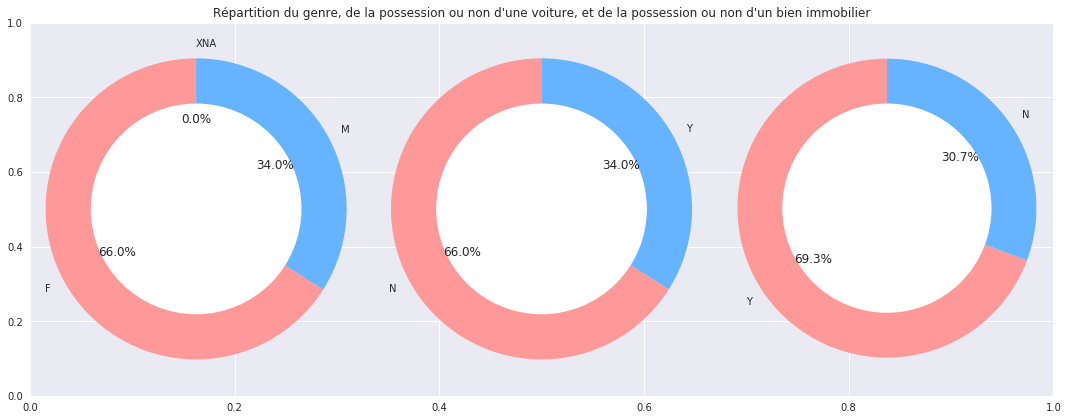

In [ ]:
# Calcul de la répartition du genre
gender = df.groupby(['CODE_GENDER'])
countgender = gender["SK_ID_CURR"].count()
countgender = countgender.sort_values(ascending=False)
genderlabels = countgender.index
gendersizes = countgender.values

gender_dict = {}
for n in range(len(genderlabels)):
    gender_dict[genderlabels[n]] = gendersizes[n]
print ("Répartition des variables du genre: ", gender_dict)

# Calcul de la répartition des voitures
car = df.groupby(['FLAG_OWN_CAR'])
countcar = car["SK_ID_CURR"].count()
countcar = countcar.sort_values(ascending=False)
carlabels = countcar.index
carsizes = countcar.values

car_dict = {}
for n in range(len(carlabels)):
    car_dict[carlabels[n]] = carsizes[n]
print ("Répartition des variables de la possession de voiture: ", car_dict)

# Calcul de la répartition des biens immobiliers
own = df.groupby(['FLAG_OWN_REALTY'])
countown = own["SK_ID_CURR"].count()
countown = countown.sort_values(ascending=False)
ownlabels = countown.index
ownsizes = countown.values

own_dict = {}
for n in range(len(ownlabels)):
    own_dict[ownlabels[n]] = ownsizes[n]
print ("Répartition des variables de la possession d'un bien immobilier: ",
       own_dict)

# Affichage des répartitions
sns.set()
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
fig = plt.figure(figsize=(15, 6))
plt.title("Répartition du genre, de la possession ou non d'une voiture,"
          "et de la possession ou non d'un bien immobilier", loc='center')
ax1 = fig.add_subplot(131)
ax1.pie(gendersizes, colors=colors, labels=genderlabels, autopct='%1.1f%%',
        startangle=90)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
ax2 = fig.add_subplot(132)
ax2.pie(carsizes, colors=colors, labels=carlabels, autopct='%1.1f%%',
        startangle=90)
# Draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')
plt.tight_layout()
ax3 = fig.add_subplot(133)
ax3.pie(ownsizes, colors=colors, labels=ownlabels, autopct='%1.1f%%',
        startangle=90)
# Draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax3.axis('equal')
plt.tight_layout()
plt.show()


Nous avons également des variables numériques à étudier :
- 'DAYS_EMPLOYED' correspond au nombre de jours travaillés dans la vie du demandeur, en négatif car nous parlons de jours avant la date considérée. Ici, nous pouvons voir une valeur extrême (365243 jours) pour 64648 personnes : or, cette valeur est aberrante et va donc indiquer une valeur inconnue. Il faudra donc remplacer cette valeur par NaN pour plus de cohérence.
- DAYS_BIRTH est le nombre de jours de vie du demandeur, en négatif car nous parlons de jours avant la date considérée. Il ne semble cette fois pas y avoir de valeurs aberrantes, cette variable restera telle-quelle
- CNT_FAM_MEMBERS indique le nombre de personnes du foyer du demandeur. Ce nombre est compris majoritairement entre 1 et 5, même si d'autres valeurs plus hautes semblent être possibles (environ 500 cas entre 6 et 21)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


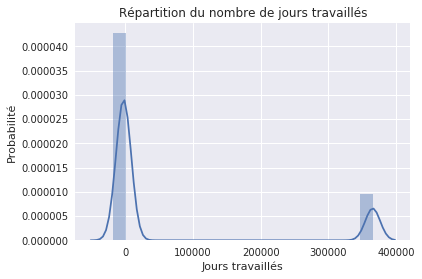

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


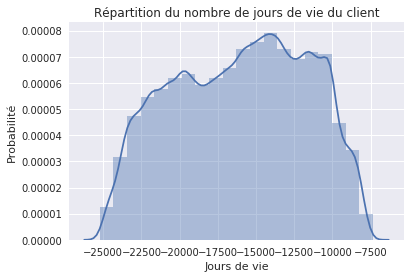

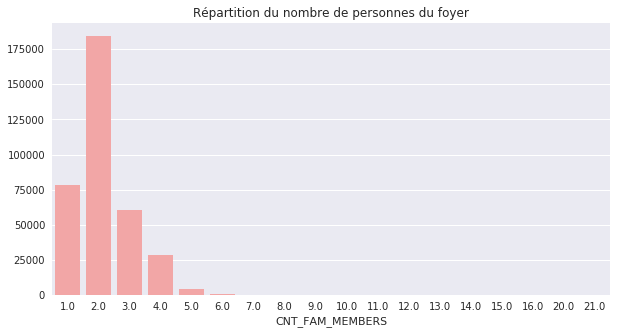

In [ ]:
# Calcul du nombre de jours travaillés
daysemp = df.groupby(["DAYS_EMPLOYED"])
countdaysemp = daysemp["SK_ID_CURR"].count()
countdaysemp = countdaysemp.sort_values(ascending=False)
daysemplabels = countdaysemp.index
daysempsizes = countdaysemp.values

daysemp_dict = {}
for n in range(len(daysemplabels)):
    daysemp_dict[daysemplabels[n]] = daysempsizes[n]

sns.set()
kwargs = {'cumulative': True}
sns.distplot(df["DAYS_EMPLOYED"], bins=20)
plt.xlabel('Jours travaillés')
plt.ylabel(u'Probabilité')
plt.title("Répartition du nombre de jours travaillés", loc='center')

plt.grid(True)
plt.show()

# Calcul du nombre de jours de vie
birth = df.groupby(["DAYS_BIRTH"])
countbirth = birth["SK_ID_CURR"].count()
countbirth = countbirth.sort_values(ascending=False)
birthlabels = countbirth.index
birthsizes = countbirth.values

birth_dict = {}
for n in range(len(birthlabels)):
    birth_dict[birthlabels[n]] = birthsizes[n]

sns.set()
kwargs = {'cumulative': True}
sns.distplot(df["DAYS_BIRTH"], bins=20)
plt.xlabel('Jours de vie')
plt.ylabel(u'Probabilité')
plt.title("Répartition du nombre de jours de vie du client", loc='center')

plt.grid(True)
plt.show()

# Calcul du nombre de personnes du foyer
fam = df.groupby(["CNT_FAM_MEMBERS"])
countfam = fam["SK_ID_CURR"].count()
countfam = countfam.sort_values(ascending=False)
famlabels = countfam.index
famsizes = countfam.values

fam_dict = {}
for n in range(len(famlabels)):
    fam_dict[famlabels[n]] = famsizes[n]
sns.set()
fig1, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(x=famlabels, y=famsizes, color='#ff9999', ax=ax1)
plt.title("Répartition du nombre de personnes du foyer")
plt.show()


- AMT_INCOME_TOTAL correspond aux revenus totaux de la personne. Nous pouvons voir que la grande majorité des personnes a un revenu inférieur à 500 000 dollars, même si cela peut monter jusqu'à 120 000 000 euros pour certains extrêmes.
- AMT_CREDIT est la valeur qu'a demandé le client. Cette valeur est majoratairement inférieur à 2 000 000 dollars, même si des extrêmes existent (jusqu'à 4 000 000). Plus de la moitié des crédit ne dépassent pas 500 000 dollars. 
- AMT_ANNUITY indique la valeur que devrait rembourser le client par an, en comprenant les intérêts. Cette somme est généralement inférieure à 100 000 dollars/an, la majorité étant même inférieure à 30 000 dollars/an.

Pour toutes ces variables numériques, il pourrait donc être intéressant d'étudier leurs interactions par le biais de pourcentages et de taux.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


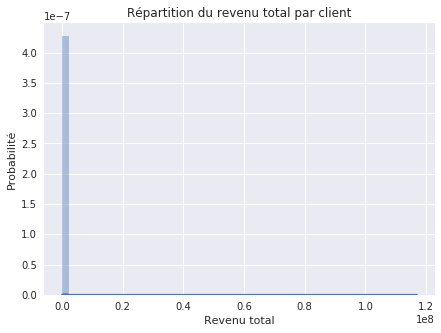

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


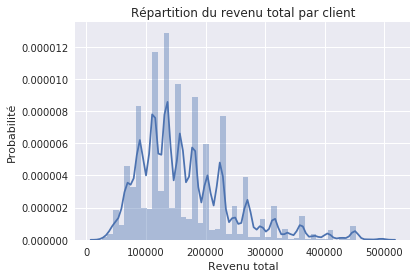

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


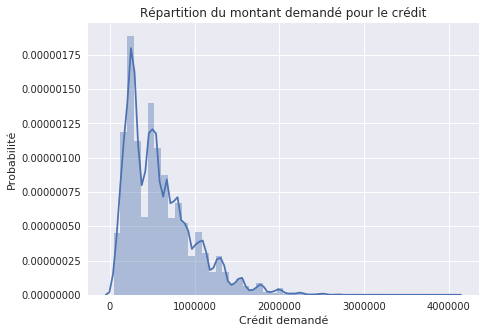

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


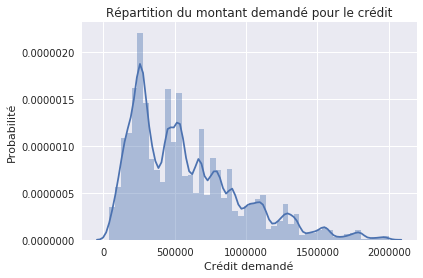

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


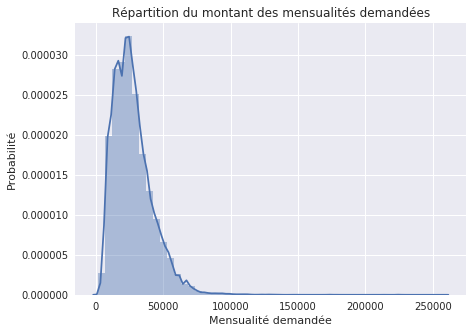

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


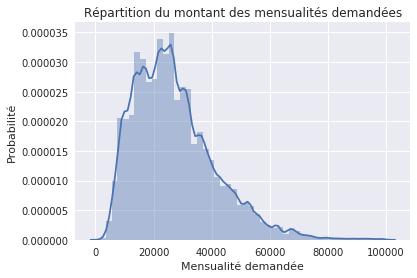

In [ ]:
# Calcul des revenus totaux
plt.figure(figsize=(7, 5))
sns.distplot(df['AMT_INCOME_TOTAL'])
plt.xlabel('Revenu total')
plt.ylabel(u'Probabilité')
plt.title("Répartition du revenu total par client", loc='center')
plt.show()
# Calcul des revenus totaux sans les valeurs hautes extrêmes
income = df[df['AMT_INCOME_TOTAL'] <= 0.5E6]
sns.set()
sns.distplot(income['AMT_INCOME_TOTAL'])
plt.xlabel('Revenu total')
plt.ylabel(u'Probabilité')
plt.title("Répartition du revenu total par client", loc='center')

plt.grid(True)
plt.show()

# Calcul des valeurs de crédits demandées
plt.figure(figsize=(7, 5))
sns.distplot(df['AMT_CREDIT'])
plt.xlabel('Crédit demandé')
plt.ylabel(u'Probabilité')
plt.title("Répartition du montant demandé pour le crédit", loc='center')
plt.show()
# Calcul des revenus totaux sans les valeurs hautes extrêmes
credit = df[df['AMT_CREDIT'] <= 2E6]
sns.set()
sns.distplot(credit['AMT_CREDIT'])
plt.xlabel('Crédit demandé')
plt.ylabel(u'Probabilité')
plt.title("Répartition du montant demandé pour le crédit", loc='center')

plt.grid(True)
plt.show()

# Calcul des valeurs de mensualités
plt.figure(figsize=(7, 5))
AA = df['AMT_ANNUITY']
AAnan = AA[~np.isnan(AA)]
sns.distplot(AAnan)
plt.xlabel('Mensualité demandée')
plt.ylabel(u'Probabilité')
plt.title("Répartition du montant des mensualités demandées", loc='center')

plt.show()
# Calcul des revenus totaux sans les valeurs hautes extrêmes
credit = AAnan[AAnan <= 100000]
sns.set()
sns.distplot(credit)
plt.xlabel('Mensualité demandée')
plt.ylabel(u'Probabilité')
plt.title("Répartition du montant des mensualités demandées", loc='center')

plt.grid(True)
plt.show()


Une fois ces variables analysées, nous réalisons donc la fonction qui traitera ces deux fichiers:
- On assemble les deux fichiers
- On retire les demandes dont le genre de la personne n'est pas remplie
- On harmonise le codage binaire des variables catégorielles binaires
- On transforme les variables catégorielles non binaires
- On retire les valeurs aberrantes pour les mettre en NaN.
- On crée de nouvelles variables à partir des variables numériques présentées auparavant :
 - le pourcentage de jours travaillés par rapport à son nombre de jours en vie
 - le pourcentage que représente la valeur du crédit sur le revenu total de la personne
 - le revenu moyen apporté par personne du foyer
 - le pourcentage annuel de l'annuité sur le revenu total de la personne
 - le taux que  représente l'annuité par rapport au coût total du crédit

In [ ]:
# Pré-processing des fichiers "application_train.csv" et "application_test.csv"
# Pas de débogguage ici donc None, et pas besoin de considérer les NaN comme de
# potentielles catégories dans cette fonction


def application_train_test(num_rows=None, nan_as_category=False):
    print ("\n1) Importation des fichiers et concaténation")
    # Importation du fichier entier ("None")"application_train.csv"
    df = pd.read_csv('application_train.csv', sep=',', nrows=num_rows)
    # Importation du fichier entier ("None") "application_test.csv"
    test_df = pd.read_csv('application_test.csv', sep=',', nrows=num_rows)
    # Concaténation des échantillons tests
    # à la suite des échantillons train, en remettant l'index par défaut
    df = df.append(test_df).reset_index()
    print ("\n2) Tri des variables (retrait des XNA aberrants pour le sexe")
    # Retrait des 4 demandes dont le sexe de la personne n'est pas connue (XNA)
    df = df[df['CODE_GENDER'] != 'XNA']
    # Harmonisation de l'encodage binaire des variables catégorielles binaires
    # (au final 2 catégories : 0 / 1)
    # Catégories utilisées :
    # - CODE_GENDER : sexe de la personne faisant la demande
    # - FLAG_OWN_CAR : si la personne a une voiture
    # - FLAG_OWN_REALTY : si la personne a un bien immobilier
    print ("\n3) Transformation des valeurs des variables catégorielles"
           "binaires en numérique (0/1)")
    print ("Exemple des variables catégorielles avant traitement"
           ":\n {}".format(
               df[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']][0:10]))
    print ("Valeurs uniques de CODE_GENDER : {}\nValeurs uniques de"
           "FLAG_OWN_CAR : {}\nValeurs uniques de FLAG_OWN_REALTY : {}".format(
               len(df['CODE_GENDER'].unique()),
               len(df['FLAG_OWN_CAR'].unique()),
               len(df['FLAG_OWN_REALTY'].unique())))
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        # Les valeurs binaires sont conservées dans le dataframe,
        # et les valeurs uniques sont tout de même disponibles
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        print ("Transformation des valeurs pour {} : {}".format(
            bin_feature, (df[bin_feature][0], uniques[0])))
    # Traitement de toutes les variables catégorielles non binaires
    print("\n4) Transformation des variables catégorielles non binaires"
          "en tableau numérique")
    print ("Nombre de variables avant transformation : {}".format(len(
        df.columns)))
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    print ("Nombre de variables après transformation : {}".format(
        len(df.columns)))
    # Transformation des hautes valeurs positives de DAYS_EMPLOYED (nb jours
    # occupés à son job actuel) en inconnues (car forcément
    # valeurs négatives ?) Ici la valeur d'inconnue est ainsi 365.243
    print ("\n5) Transformation des hautes valeurs positives de DAYS_EMPLOYED"
           "en NaN")
    print ("Nombre de valeurs inconnues pour DAYS_EMPLOYED avant "
           "transformation: {} valeurs".format(
               df['DAYS_EMPLOYED'].isnull().sum()))
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    print ("Nombre de valeurs inconnues pour DAYS_EMPLOYED après"
           "transformation : {} valeurs".format(
               df['DAYS_EMPLOYED'].isnull().sum()))
    # Création de nouvelles features à partir d'existantes (création de %)
    print ("\n6) Création des features de pourcentage")
    # Pourcentage de temps travaillé dans le job actuel par rapport
    # à son nombre de jours en vie
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    print ("Aperçu de la variable DAYS_EMPLOYED_PERC :\n {} ".format(
        df[['DAYS_EMPLOYED_PERC', 'DAYS_EMPLOYED', 'DAYS_BIRTH']][0:2]))
    #  Pourcentage que représente la valeur du crédit sur
    # le revenu total de la personne
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    print ("Aperçu de la variable INCOME_CREDIT_PERC :\n {} ".format(
        df[['INCOME_CREDIT_PERC', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']][0:2]))
    # Revenu moyen apporté par personne du foyer
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    print ("Aperçu de la variable INCOME_PER_PERSON :\n {} ".format(
        df[['INCOME_PER_PERSON', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']][0:2]))
    # Pourcentage de revenu mensuel sur l'annuel -> savoir si revenu
    # brut ou primes ?
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    print ("Aperçu de la variable ANNUITY_INCOME_PERC :\n {} ".format(
        df[['ANNUITY_INCOME_PERC', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL']][0:2]))
    # Taux que représente l'apport du crédit par rapport à la somme totale
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    print ("Aperçu de la variable PAYMENT_RATE :\n {} ".format(
        df[['PAYMENT_RATE', 'AMT_ANNUITY', 'AMT_CREDIT']][0:2]))
    # Suppression du fichier "application_test" car rassemblé
    # dans le fichier "application_train"
    del test_df
    gc.collect()  # Nettoyage des variables maintenant plus utilisées
    return df


# 3) Fichiers "bureau.csv" et "bureau_balance.csv"

Le fichier "bureau.csv" va indiquer les crédits contractés précédemment par les demandeurs dans d'autres instituts. Pour compléter ce document, le fichier "bureau_balance.csv" indique pour chaque mois le statut de ces crédits.   

In [ ]:
# Importation du fichier entier ("None") "bureau.csv"
bureau = pd.read_csv('bureau.csv', sep=',')
# Importation du fichier entier ("None") "bureau_balance.csv"
bb = pd.read_csv('bureau_balance.csv', sep=',')
print("Taille échantillons bureau: {} demandes \nTaille échantillon"
      "bureau_balance: {} demandes".format(len(bureau), len(bb)))
print("Nombre de variables du fichier bureau : {} variables".format(
      len(bureau.columns)))
print("Nombre de variables du fichier bureau_balance : {} variables".format(
      len(bb.columns)))


Taille échantillons bureau: 1716428 demandes 
Taille échantillon bureau_balance: 27299925 demandes
Nombre de variables du fichier bureau : 17 variables
Nombre de variables du fichier bureau_balance : 3 variables


Nous n'avons ici pas de variables catégorielles binaires à étudier, uniquement des variables catégorielles non-binaires, transformées par la fonction 'one_hot_encoder" créée précédemment, et des variables numériques que nous allons analyser en partie.

La seule variable numérique étudiable de "bureau_balance" est "MONTHS_BALANCE". Cette variable consiste à répertorier les mois avant la demande actuelle pour laquelle le crédit était à payer. Si plus de 40000 personnes ont un crédit depuis 96 mois, le reste s'étale jusqu'à des crédits débutés au mois actuel. 

             MONTHS_BALANCE
                        min
SK_ID_BUREAU               
5001709                 -96
5001710                 -82
5001711                  -3
5001712                 -18
5001713                 -21
5001714                 -14
5001715                 -59
5001716                 -85
5001717                 -21
5001718                 -38
5001719                 -42
5001720                 -35
5001721                 -84
5001722                 -85
5001723                 -30
5001724                 -30
5001725                  -7
5001726                 -38
5001727                 -94
5001728                   0
5001729                  -6
5001730                 -60
5001731                 -10
5001732                 -35
5001733                 -10
5001734                  -2
5001735                 -23
5001736                 -23
5001737                 -21
5001738                 -43
...                     ...
6842859                 -35
6842860             

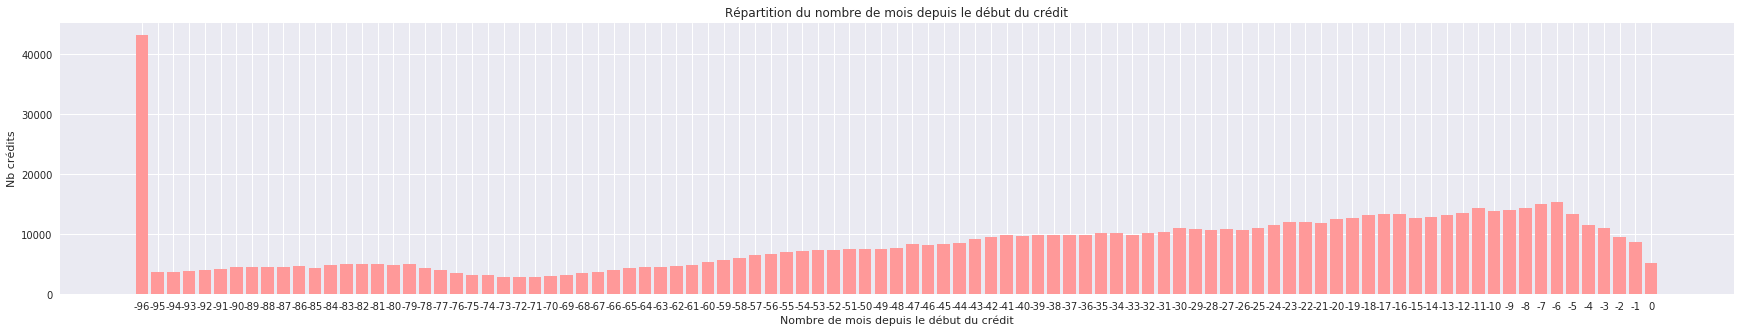

In [ ]:
bb_aggregations = {'MONTHS_BALANCE': ['min']}
bb_gb = bb.groupby('SK_ID_BUREAU')
bb_agg = bb_gb.agg(bb_aggregations)

print (bb_agg)

monthsb_dict = {}
for n in bb_agg['MONTHS_BALANCE']['min'].unique():
    monthsb_dict[n] = 0
for n in bb_agg['MONTHS_BALANCE']['min']:
    monthsb_dict[n] += 1
print ("Avant nettoyage pour visualisation : ", monthsb_dict)

monthsb_dict = OrderedDict(sorted(monthsb_dict.items()))

sns.set()
plt.bar(range(len(monthsb_dict)), list(monthsb_dict.values()), align='center',
        color='#ff9999')
plt.xticks(range(len(monthsb_dict)), list(monthsb_dict.keys()))
plt.gcf().set_size_inches(30, 5)
plt.xlabel('Nombre de mois depuis le début du crédit')
plt.ylabel('Nb crédits')
plt.title('Répartition du nombre de mois depuis le début du crédit')
plt.show()


Comme c'est l'unique valeur étudiée pour ce fichier, et que les deux fichiers de cette partie sont liés, nous les rassemblons dans un seul et unique fichier. Ensuite, nous étudions les autres variables numériques pouvant nous intéresser, et pouvant subir des aggrégations.

- DAYS_CREDIT est le nombre de jours entre la demande précédente et actuelle du client. La moitié des clients a fait sa demande moins de 300 jours avant la précédente, mais l'autre moitié a un délai compris entre ces 300 jours et 3000 (environ 8 ans), ce qui est très disparate.
- DAYS_CREDIT_ENDDATE indique le nombre de jours restants avant la fin du remboursement du précédent crédit. Cette valeur est majoritairement entre 0 et 300 jours, même si des valeurs extrêmes sont disponibles, que ce soient en négatifs (crédits clos) ou positifs (crédits actifs). 
- DAYS_CREDIT_UPDATE indique le nombre de jours depuis la dernière mise à jour des informations sur le crédit (paiement,...). Plus de la moitié a eu une mise à jour il y a moins de 500 jours, mais cela peut monter jusqu'à plus de 2000 jours.
- CREDIT_DAY_OVERDUE correspond au nombre de jours de retard de paiement au jour de la demande actuelle. La majorité a maximum un jour de retard.
- CNT_CREDIT_PROLONG indique le nombre de fois où le crédit a été prolongé. Pour la majorité, cela s'est fait 2 fois ou moins.
    
    

In [ ]:
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                          for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')


In [ ]:
bureau_aggregations = {'DAYS_CREDIT': ['max'], 'DAYS_CREDIT_ENDDATE': ['min'],
                       'DAYS_CREDIT_UPDATE': ['mean'],
                       'CREDIT_DAY_OVERDUE': ['mean'],
                       'CNT_CREDIT_PROLONG': ['sum']}
bureau_gb = bureau.groupby('SK_ID_CURR')
bureau_agg = bureau_gb.agg(bureau_aggregations)
bureau_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                              for e in bureau_agg.columns.tolist()])


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


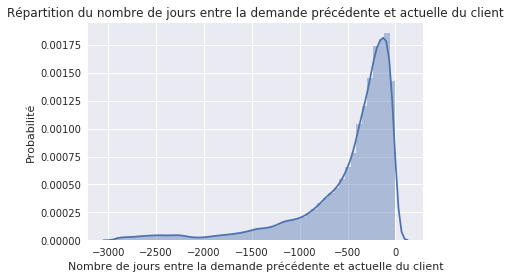

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


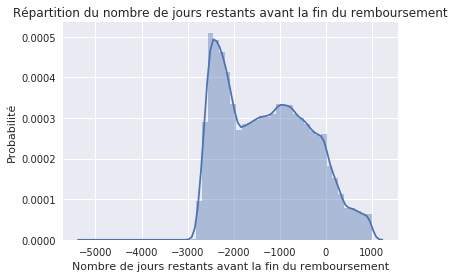

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


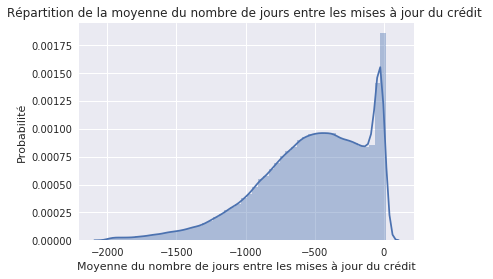

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


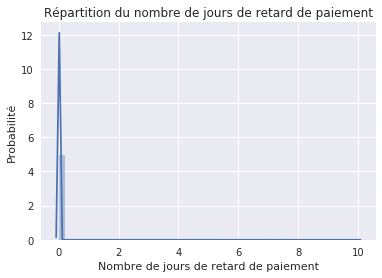

Index(['DAYS_CREDIT_MAX', 'DAYS_CREDIT_ENDDATE_MIN', 'DAYS_CREDIT_UPDATE_MEAN',
       'CREDIT_DAY_OVERDUE_MEAN', 'CNT_CREDIT_PROLONG_SUM'],
      dtype='object')


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


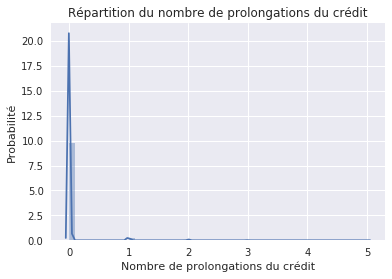

In [ ]:
sns.set()
sns.distplot(bureau_agg['DAYS_CREDIT_MAX'])
plt.xlabel('Nombre de jours entre la demande précédente et actuelle du client')
plt.ylabel(u'Probabilité')
plt.title('Répartition du nombre de jours entre la demande précédente et'
          'actuelle du client')
plt.grid(True)
plt.show()

enddate = bureau_agg[(bureau_agg['DAYS_CREDIT_ENDDATE_MIN'] >= -10000) &
                     (bureau_agg['DAYS_CREDIT_ENDDATE_MIN'] <= 1000)]

sns.set()
sns.distplot(enddate['DAYS_CREDIT_ENDDATE_MIN'])
plt.xlabel('Nombre de jours restants avant la fin du remboursement')
plt.ylabel(u'Probabilité')
plt.title('Répartition du nombre de jours restants avant la fin du'
          'remboursement')
plt.grid(True)
plt.show()

update = bureau_agg[bureau_agg['DAYS_CREDIT_UPDATE_MEAN'] >= -2000]

sns.set()
sns.distplot(update['DAYS_CREDIT_UPDATE_MEAN'])
plt.xlabel('Moyenne du nombre de jours entre les mises à jour du crédit')
plt.ylabel(u'Probabilité')
plt.title('Répartition de la moyenne du nombre de jours entre les mises à'
          'jour du crédit ')
plt.grid(True)
plt.show()

late = bureau_agg[bureau_agg['CREDIT_DAY_OVERDUE_MEAN'] <= 10]

sns.set()
sns.distplot(late['CREDIT_DAY_OVERDUE_MEAN'])
plt.xlabel('Nombre de jours de retard de paiement')
plt.ylabel(u'Probabilité')
plt.title('Répartition du nombre de jours de retard de paiement')
plt.grid(True)
plt.show()

print (bureau_agg.columns)

cnt = bureau_agg[bureau_agg['CNT_CREDIT_PROLONG_SUM'] <= 5]

sns.set()
sns.distplot(cnt['CNT_CREDIT_PROLONG_SUM'])
plt.xlabel('Nombre de prolongations du crédit')
plt.ylabel(u'Probabilité')
plt.title('Répartition du nombre de prolongations du crédit')
plt.grid(True)
plt.show()


- AMT_CREDIT_MAX_OVERDUE correspond au montant maximal des impayés du crédit. Il est à 90% inférieur à 100 000 dollars 
- AMT_CREDIT_SUM' indique le montant actuel du crédit. Il est à 70% inférieur à 4000 dollars, et à 90% inférieur à 8000 dollars.
- AMT_CREDIT_SUM_DEBT' est le montant de la dette actuelle sur le crédit (combien il reste à payer). Il reste pour plus de 90% des crédits moins de 500 000 dollars à payer
- AMT_CREDIT_SUM_OVERDUE' correspond à la somme actuelle des impayés du crédit (au moment de la demande actuelle). Elle est de moins de 60 pour 99% des clients
- AMT_CREDIT_SUM_LIMIT' indique la limite du crédit sur les cartes de crédit. Elle est de maximum 300 000 dollars dans 99% des cas.
- AMT_ANNUITY est le montant versé chaque année par le crédit. Il est de 100 000 et moins pour plus de 99% des clients.

In [ ]:
bureau_aggregations = {'AMT_CREDIT_MAX_OVERDUE': ['mean'],
                       'AMT_CREDIT_SUM': ['mean'],
                       'AMT_CREDIT_SUM_DEBT': ['mean'],
                       'AMT_CREDIT_SUM_LIMIT': ['mean'],
                       'AMT_CREDIT_SUM_OVERDUE': ['mean'],
                       'AMT_ANNUITY': ['mean']}
bureau_gb = bureau.groupby('SK_ID_CURR')
bureau_agg = bureau_gb.agg(bureau_aggregations)
bureau_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                              for e in bureau_agg.columns.tolist()])


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


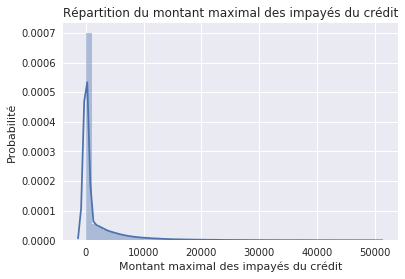

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


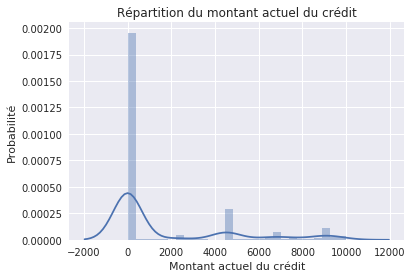

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


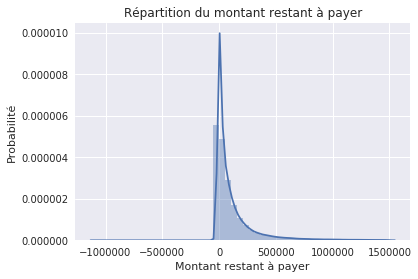

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


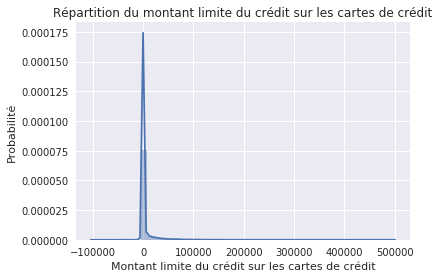

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


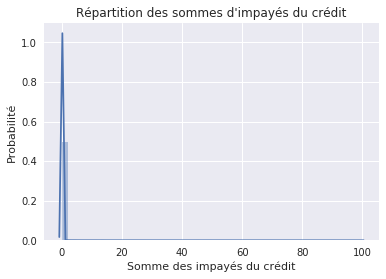

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


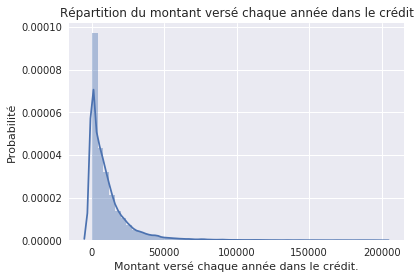

In [ ]:
maxoverdue = bureau_agg[bureau_agg['AMT_CREDIT_MAX_OVERDUE_MEAN'] <= 50E3]

sns.set()
sns.distplot(maxoverdue['AMT_CREDIT_MAX_OVERDUE_MEAN'])
plt.xlabel('Montant maximal des impayés du crédit')
plt.ylabel(u'Probabilité')
plt.title('Répartition du montant maximal des impayés du crédit')
plt.grid(True)
plt.show()

credsum = bureau_agg[bureau_agg['AMT_CREDIT_SUM_MEAN'] <= 0.1E5]

sns.set()
sns.distplot(credsum['AMT_CREDIT_SUM_MEAN'])
plt.xlabel('Montant actuel du crédit')
plt.ylabel(u'Probabilité')
plt.title("Répartition du montant actuel du crédit")
plt.grid(True)
plt.show()

sumdebt = bureau_agg[bureau_agg['AMT_CREDIT_SUM_DEBT_MEAN'] <= 1.5E6]

sns.set()
sns.distplot(sumdebt['AMT_CREDIT_SUM_DEBT_MEAN'])
plt.xlabel('Montant restant à payer')
plt.ylabel(u'Probabilité')
plt.title("Répartition du montant restant à payer")
plt.grid(True)
plt.show()

sumdebt = bureau_agg[bureau_agg['AMT_CREDIT_SUM_LIMIT_MEAN'] <= 0.5E6]

sns.set()
sns.distplot(sumdebt['AMT_CREDIT_SUM_LIMIT_MEAN'])
plt.xlabel('Montant limite du crédit sur les cartes de crédit')
plt.ylabel(u'Probabilité')
plt.title("Répartition du montant limite du crédit sur les cartes de crédit")
plt.grid(True)
plt.show()

sumover = bureau_agg[bureau_agg['AMT_CREDIT_SUM_OVERDUE_MEAN'] <= 100]

sns.set()
sns.distplot(sumover['AMT_CREDIT_SUM_OVERDUE_MEAN'])
plt.xlabel('Somme des impayés du crédit')
plt.ylabel(u'Probabilité')
plt.title("Répartition des sommes d'impayés du crédit")
plt.grid(True)
plt.show()


annuity = bureau_agg[bureau_agg['AMT_ANNUITY_MEAN'] <= 0.2E6]

sns.set()
sns.distplot(annuity['AMT_ANNUITY_MEAN'])
plt.xlabel('Montant versé chaque année dans le crédit.')
plt.ylabel(u'Probabilité')
plt.title("Répartition du montant versé chaque année dans le crédit")
plt.grid(True)
plt.show()


Après réflexion, une variable catégorielle non binaire peut nous intéresser : la variable "CREDIT_ACTIVE". En effet, elle nous permet de savoir si un crédit est encore actif ou non, et peut nous aider à savoir combien de temps représente chaque statut pour un crédit. Ainsi, on obtiendra à la fin un fichier contenant les statistiques totales du crédit, les statistiques sur le temps où le crédti était actif, et celles sur le temps où le crédit était clos, (donc essentiellement le nombre de jours de clôture)

Une fois ces variables analysées, nous réalisons donc la fonction qui traitera ces deux fichiers:
- On transforme les variables catégorielles non binaires
- On crée des aggrégations pour les variables numériques d'intérêt vues précédemment, afin d'en tirer des renseignements statisques (min, max, moyenne, ...) tout d'abord sur le fichier balance, puis après assemblage des deux fichiers, sur le fichier total.
- On sépare les crédits actifs des clos pour indiquer leurs statistiques particulières durant ces périodes.

In [ ]:
# Pré-processing des fichiers 'bureau.csv' et 'bureau_balance.csv'
# (précédents crédits dans d'autres instituts)
# Pas de débogguage ici donc None, et considération des NaN comme de
# potentielles catégories dans cette fonction


def bureau_and_balance(num_rows=None, nan_as_category=True):
    print ("\n1) Importation des fichiers")
    # Importation du fichier entier ("None") "bureau.csv"
    bureau = pd.read_csv('bureau.csv', sep=',', nrows=num_rows)
    # Importation du fichier entier ("None") "bureau_balance.csv"
    bb = pd.read_csv('bureau_balance.csv', sep=',', nrows=num_rows)
    print("Taille échantillons bureau: {} demandes \nTaille échantillon"
          "bureau_balance: {} demandes".format(len(bureau), len(bb)))
    # Traitement des variables catégorielles non-binaires
    print ("\n2) Traitement des variables catégorielles non-binaires :")
    print ("a) pour le fichier 'bureau'")
    # Traitement de toutes les variables catégorielles non binaires
    # du fichier bureau
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    print ("b) pour le fichier 'bureau_balance'")
    # Traitement de toutes les variables catégorielles non binaires
    # du fichier bureau_balance
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    # Aggregations du fichier "bureau_balance" -> indications du statut au
    # cours du temps des crédits précédents
    print ("\n3) Aggrégations du fichier 'bureau_balance' :")
    # Calcul futur des valeurs min, max et du temps du crédit précédent
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    print(bb["MONTHS_BALANCE"][0:10])
    for col in bb_cat:
        # Pour les autres valeurs du numéro de crédit, sortir dans le futur
        # la moyenne des valeurs
        bb_aggregations[col] = ['mean']
    # Regrouper les variables de "bureau_balance" pour numéro de crédit
    bb_gb = bb.groupby('SK_ID_BUREAU')
    # Faire les différents calculs indiqués précédents
    bb_agg = bb_gb.agg(bb_aggregations)
    print ("Fichier après aggrégation : {}\n".format(bb_agg))
    print ("Noms de colonnes avant renommage :", bb_agg.columns.tolist())
    # Renommage des colonnes d'aggrégation
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                              for e in bb_agg.columns.tolist()])
    print ("Noms de colonnes après renommage :", bb_agg.columns)
    # Regroupement des deux fichiers
    print("\n4) Regroupement des fichiers 'bureau' et 'bureau_balance'")
    # Jointure externe gauche (en privilégiant les clés de bureau)
    # basé sur l'ID Bureau
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    # On retire l'ID bureau qui ne nous servait qu'à faire cette jointure
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    # Suppression des fichiers de base "bureau" et "bureau_balance"
    del bb, bb_agg
    gc.collect()  # Nettoyage des variables maintenant plus utilisé
    # Aggregations du fichier total (variables de "bureau")
    print ("\n5) Aggrégations du fichier total"
           "(variables du fichier 'bureau') :")
    # Création future des valeurs statistiques des variables numériques
    print (bureau[['SK_ID_CURR', 'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE',
                   'DAYS_CREDIT_UPDATE']][0:10])
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    print ("Variables numériques : {}".format(num_aggregations))
    # Création future des valeurs statistiques des variables catégorielles
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']
    print ("Variables catégorielles : {}".format(cat_aggregations))
    bureau_gb = bureau.groupby('SK_ID_CURR')
    bureau_agg = bureau_gb.agg({**num_aggregations, **cat_aggregations})
    print ("Fichier après aggrégation : {}\n".format(
        bureau_agg[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE',
                    'DAYS_CREDIT_UPDATE']][0:10]))
    print ("Noms de colonnes avant renommage :", bureau_agg.columns.tolist())
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper()
                                  for e in bureau_agg.columns.tolist()])
    print ("Noms de colonnes après renommage :", bureau_agg.columns)
    # Création des variables pour crédits actifs
    print ("\n6) Indication des crédits précédents encore actifs,"
           "grâce aux aggrégations numériques")
    # Extraction des crédit actifs = fichier "bureau", variable binaire à 1
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    print ("Noms de colonnes dans la variable des crédits actifs :",
           active.columns)
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper()
                                   for e in active_agg.columns.tolist()])
    print ("Noms de colonnes après aggrégation et renommage :",
           active_agg.columns)
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    print ("Noms de colonnes après regroupement :", bureau_agg.columns)
    del active, active_agg
    gc.collect()
    # Création des variables pour crédits terminés
    print ("\n7) Indication des crédits précédents clos,"
           "grâce aux aggrégations numériques")
    # Extraction des crédit clos = fichier "bureau", variable binaire à 1
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    print ("Noms de colonnes dans la variable des crédits actifs :",
           closed.columns)
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper()
                                   for e in closed_agg.columns.tolist()])
    print ("Noms de colonnes après aggrégation et renommage :",
           closed_agg.columns)
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    print ("Noms de colonnes après regroupement :", bureau_agg.columns)
    del closed, closed_agg, bureau
    gc.collect()
    print ("Fichier final :\n Colonnes : {}\n Extrait :\n {}".format(
           bureau_agg.columns, bureau_agg[0:10]))
    return bureau_agg


# 4) Fichier "previous_application.csv"

Le fichier "previous_applications" regroupe l'intégralité des crédits passés précédemment chez Home Credit par les demandeurs actuels.

In [ ]:
prev = pd.read_csv('previous_application.csv', sep=',')
print("Taille échantillons previous_application: {} demandes".format(
    len(prev)))


Taille échantillons previous_application: 1670214 demandes


Nous n'avons ici pas de variables catégorielles binaires à étudier, uniquement des variables catégorielles non-binaires, transformées par la fonction 'one_hot_encoder" créée précédemment, et des variables numériques que nous allons analyser en partie.

Le premier type de variables numériques étudiées ici est l'ensemble des variables ayant comme unité le nombre de jours.
- 'DAYS_FIRST_DRAWING' indique le nombre de jours entre le premier remboursement du crédit et la demande actuelle.
- 'DAYS_FIRST_DUE' correspond au nombre de jours entre la première échéance du crédit précédent et la demande actuelle.
- 'DAYS_LAST_DUE_1ST_VERSION' et 'DAYS_LAST_DUE' correspondent au nombre de jours entre la dernière échéance du crédit précédente et la demande actuelle, calculées de manière différente.
- 'DAYS_TERMINATION' indique le nombre de jours entre la fin prévue du crédit précédent et la demande actuelle.

Dans tous ces cas, nous pouvons voir un grand nombre de valeurs aberrantes : nous devrons les transformer en NaN pour ne pas fausser nos résultats.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


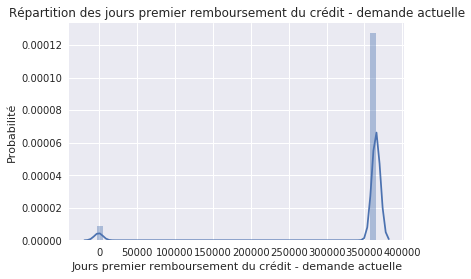

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


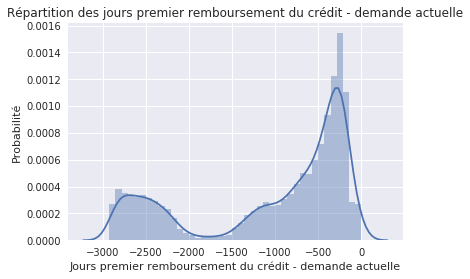

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


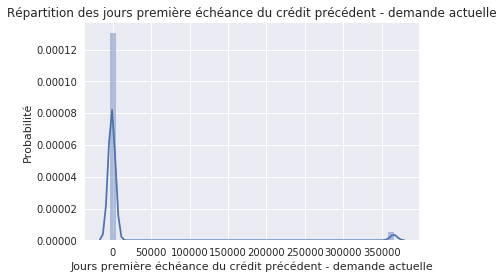

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


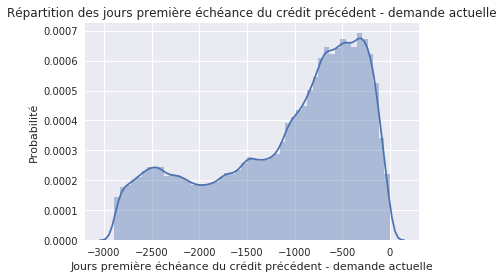

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


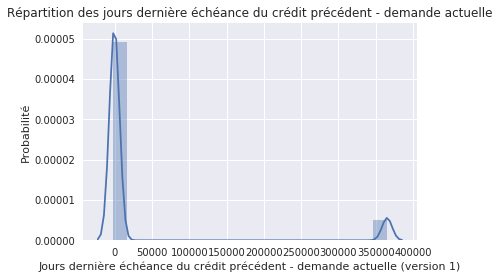

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


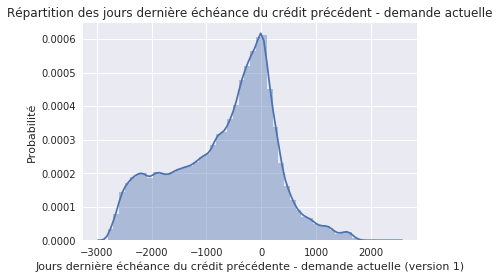

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


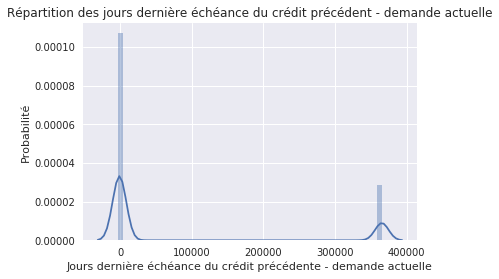

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


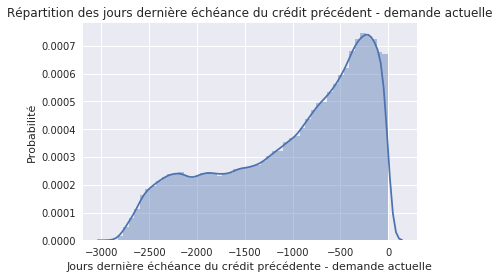

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


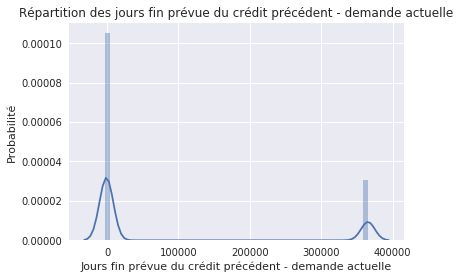

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


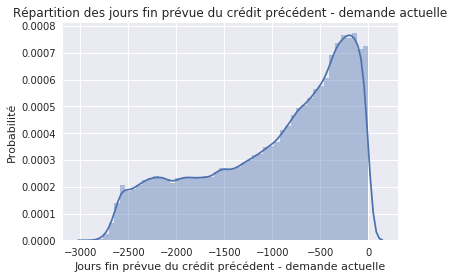

In [ ]:
sns.set()
DFD = prev["DAYS_FIRST_DRAWING"]
DFDnan = DFD[~np.isnan(DFD)]
sns.distplot(DFDnan)
plt.xlabel('Jours premier remboursement du crédit - demande actuelle')
plt.ylabel(u'Probabilité')
plt.title('Répartition des jours premier remboursement du crédit -'
          'demande actuelle')
plt.grid(True)
plt.show()

firstdraw = prev[prev["DAYS_FIRST_DRAWING"] <= 50000]

sns.set()
sns.distplot(firstdraw["DAYS_FIRST_DRAWING"])
plt.xlabel('Jours premier remboursement du crédit - demande actuelle')
plt.ylabel(u'Probabilité')
plt.title('Répartition des jours premier remboursement du crédit -'
          'demande actuelle')
plt.grid(True)
plt.show()

sns.set()
DFD = prev["DAYS_FIRST_DUE"]
DFDnan = DFD[~np.isnan(DFD)]
sns.distplot(DFDnan)
plt.xlabel('Jours première échéance du crédit précédent - demande actuelle')
plt.ylabel(u'Probabilité')
plt.title('Répartition des jours première échéance du crédit précédent -'
          'demande actuelle')
plt.grid(True)
plt.show()

firstdue = prev[prev["DAYS_FIRST_DUE"] <= 50000]

sns.set()
sns.distplot(firstdue["DAYS_FIRST_DUE"])
plt.xlabel('Jours première échéance du crédit précédent - demande actuelle')
plt.ylabel(u'Probabilité')
plt.title('Répartition des jours première échéance du crédit précédent -'
          'demande actuelle')
plt.grid(True)
plt.show()

sns.set()
DLD1 = prev['DAYS_LAST_DUE_1ST_VERSION']
DLD1nan = DLD1[~np.isnan(DLD1)]
sns.distplot(DLD1nan, bins=20)
plt.xlabel('Jours dernière échéance du crédit précédent - demande actuelle'
           '(version 1)')
plt.ylabel(u'Probabilité')
plt.title('Répartition des jours dernière échéance du crédit précédent -'
          'demande actuelle')
plt.grid(True)
plt.show()

due1 = prev[prev["DAYS_LAST_DUE_1ST_VERSION"] <= 50000]

sns.set()
sns.distplot(due1['DAYS_LAST_DUE_1ST_VERSION'])
plt.xlabel('Jours dernière échéance du crédit précédente - demande actuelle'
           '(version 1)')
plt.ylabel(u'Probabilité')
plt.title('Répartition des jours dernière échéance du crédit précédent -'
          'demande actuelle')
plt.grid(True)
plt.show()

sns.set()
DLD = prev['DAYS_LAST_DUE']
DLDnan = DLD[~np.isnan(DLD)]
sns.distplot(DLDnan)
plt.xlabel('Jours dernière échéance du crédit précédente - demande actuelle')
plt.ylabel(u'Probabilité')
plt.title('Répartition des jours dernière échéance du crédit précédent -'
          'demande actuelle')
plt.grid(True)
plt.show()

due = prev[prev["DAYS_LAST_DUE"] <= 50000]

sns.set()
sns.distplot(due['DAYS_LAST_DUE'])
plt.xlabel('Jours dernière échéance du crédit précédente - demande actuelle')
plt.ylabel(u'Probabilité')
plt.title('Répartition des jours dernière échéance du crédit précédent -'
          'demande actuelle')
plt.grid(True)
plt.show()

sns.set()
DT = prev['DAYS_TERMINATION']
DTnan = DT[~np.isnan(DT)]
sns.distplot(DTnan)
plt.xlabel('Jours fin prévue du crédit précédent - demande actuelle')
plt.ylabel(u'Probabilité')
plt.title('Répartition des jours fin prévue du crédit précédent'
          '- demande actuelle')
plt.grid(True)
plt.show()

term = prev[prev["DAYS_TERMINATION"] <= 50000]

sns.set()
sns.distplot(term['DAYS_TERMINATION'])
plt.xlabel('Jours fin prévue du crédit précédent - demande actuelle')
plt.ylabel(u'Probabilité')
plt.title('Répartition des jours fin prévue du crédit précédent'
          '- demande actuelle')
plt.grid(True)
plt.show()


Le deuxième type de variables numériques étudié est celui des variables d'aggrégation, sur lesquelles sont réalisées des calculs statistiques (min, max, moyenne,...)
- AMT_ANNUITY est le montant versé chaque année par le crédit. La moitié des clients se voit verser moins de 10 000 dollars, et plus de 99% des clients moins de 60 000 dollars.
- 'AMT_APPLICATION' est le montant du crédit demandé par le client. La moitié des clients demandent moins de 100000 dollars, et plus de 99% des clients moins de 1 500 000 dollars.
- 'AMT_CREDIT' est le montant du crédit obtenu par le client (différence selon avis de l'organisme + ajout d'assurances). La moitié des clients demandent moins de 100000 dollars, et plus de 99% des clients moins de 1 500 000 dollars.

A partir des deux variables précédents, on crée une variable permettant d'indiquer le pourcentage de crédit obtenu par rapport à celui demandé, APP_CREDIT_PERC

- 'AMT_DOWN_PAYMENT' est le montant de l'acompte versé par le client pour le crédit. Il est de moins de 5000 dollars pour la moitié des clients, et de moins de 60 000 dollars pour 99% des clients. 
- 'AMT_GOODS_PRICE' indique le prix des biens demandés par le client via ce crédit, dans le cas de crédit à la consommation. Ils représentent moins de 10 000 dollars pour la moitié des clients, et moins de 1 500 000 pour 99% des clients.
- 'HOUR_APPR_PROCESS_START' représente l'heure où a été réalisée la demande. Les demandes sont comprises entre 8h et 18h, ce qui semble normal.
- 'RATE_DOWN_PAYMENT' indique le taux de l'acompte normalisé. Il représente moins de 10% pour plus de la moitié des clients, et moins de 50% pour 99% des clients.
- 'DAYS_DECISION' indique le nombre de jours entre le jour de la prise de décision de la demande précédente et la demande actuelle. Il s'est passé moins de 500 jours pour la moitié des clients, et jusqu'à 3000 jours (environ 8 ans) pour les extrêmes.
- 'CNT_PAYMENT est le nombre de paiements déjà effectués pour le crédit. La moitié en a réalisé moins de 15, plus de 99% des clients moins de 60.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


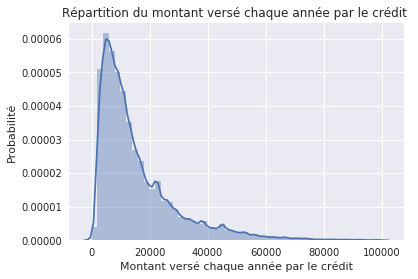

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


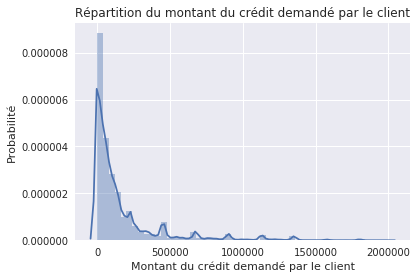

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


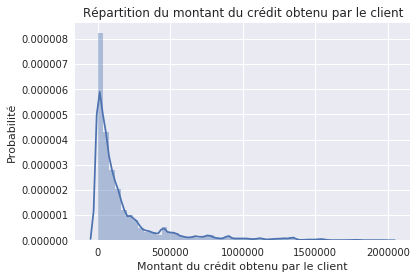

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


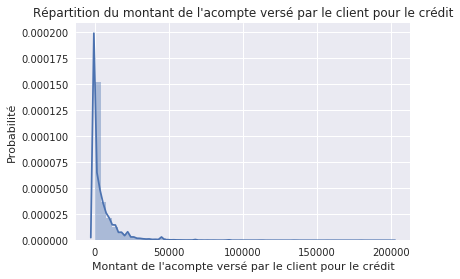

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


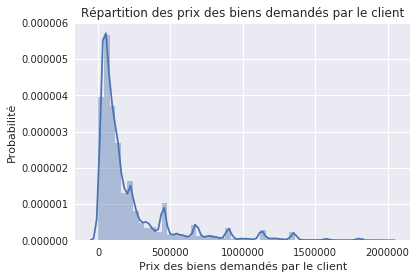

In [ ]:
annuity = prev[prev['AMT_ANNUITY'] <= 1E5]

sns.set()
sns.distplot(annuity['AMT_ANNUITY'])
plt.xlabel('Montant versé chaque année par le crédit')
plt.ylabel(u'Probabilité')
plt.title('Répartition du montant versé chaque année par le crédit ')
plt.grid(True)
plt.show()

appli = prev[prev['AMT_APPLICATION'] <= 2E6]

sns.set()
sns.distplot(appli['AMT_APPLICATION'])
plt.xlabel('Montant du crédit demandé par le client')
plt.ylabel(u'Probabilité')
plt.title('Répartition du montant du crédit demandé par le client')
plt.grid(True)
plt.show()

credit = prev[prev['AMT_CREDIT'] <= 2E6]

sns.set()
sns.distplot(credit['AMT_CREDIT'])
plt.xlabel('Montant du crédit obtenu par le client')
plt.ylabel(u'Probabilité')
plt.title('Répartition du montant du crédit obtenu par le client')
plt.grid(True)
plt.show()

down = prev[prev['AMT_DOWN_PAYMENT'] <= 0.2E6]

sns.set()
sns.distplot(down['AMT_DOWN_PAYMENT'])
plt.xlabel('Montant de l\'acompte versé par le client pour le crédit')
plt.ylabel(u'Probabilité')
plt.title('Répartition du montant de l\'acompte versé par le client pour'
          'le crédit')
plt.grid(True)
plt.show()

goods = prev[prev['AMT_GOODS_PRICE'] <= 2E6]

sns.set()
sns.distplot(goods['AMT_GOODS_PRICE'])
plt.xlabel('Prix des biens demandés par le client')
plt.ylabel(u'Probabilité')
plt.title("Répartition des prix des biens demandés par le client")
plt.grid(True)
plt.show()


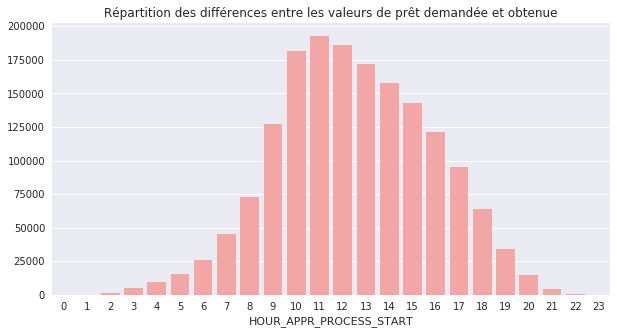

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


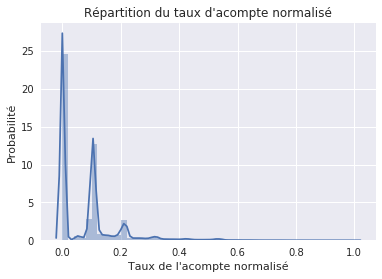

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


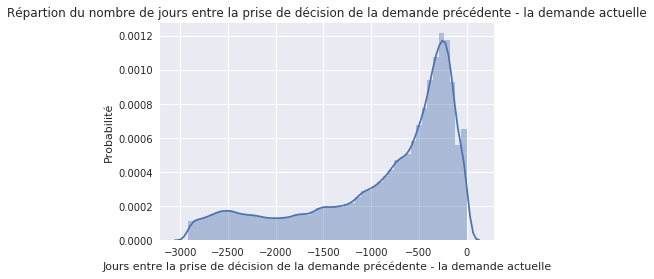

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


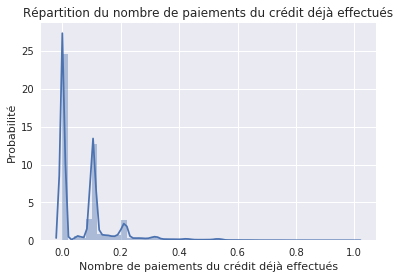

In [ ]:
hours = prev.groupby(["HOUR_APPR_PROCESS_START"])
counthours = hours["SK_ID_PREV"].count()
counthours = counthours.sort_values(ascending=False)
hourslabels = counthours.index
hourssizes = counthours.values

sns.set()
fig1, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(x=hourslabels, y=hourssizes, color='#ff9999', ax=ax1)
plt.title("Répartition des différences entre les valeurs de prêt demandée"
          "et obtenue")
plt.show()

sns.set()
RDP = prev['RATE_DOWN_PAYMENT']
RDPnan = RDP[~np.isnan(RDP)]
sns.distplot(RDPnan)
plt.xlabel('Taux de l\'acompte normalisé')
plt.ylabel(u'Probabilité')
plt.title("Répartition du taux d'acompte normalisé")
plt.grid(True)
plt.show()

sns.set()
sns.distplot(prev['DAYS_DECISION'])
plt.xlabel('Jours entre la prise de décision de la demande précédente -'
           'la demande actuelle')
plt.ylabel(u'Probabilité')
plt.title("Répartion du nombre de jours entre la prise de décision de la"
          "demande précédente - la demande actuelle")
plt.grid(True)
plt.show()

sns.set()
CP = prev['RATE_DOWN_PAYMENT']
CPnan = CP[~np.isnan(CP)]
sns.distplot(CPnan)
plt.xlabel('Nombre de paiements du crédit déjà effectués')
plt.ylabel(u'Probabilité')
plt.title("Répartition du nombre de paiements du crédit déjà effectués")
plt.grid(True)
plt.show()


Après réflexion, une variable catégorielle non binaire peut nous intéresser : la variable "NAME_CONTRACT_STATUS". En effet, elle nous permet de savoir si un crédit a été accepté ou non, et peut nous aider à savoir les statistiques pour chaque type de crédit. Ainsi, on obtiendra à la fin un fichier contenant les statistiques des crédits acceptés, et les statistiques des créditr refusés.

Une fois ces variables analysées, nous réalisons donc la fonction qui traitera ce fichier :
- On transforme les variables catégorielles non binaires
- On transforme les variables en jour pour en retirer les valeurs aberrantes et indiquer NaN.
- On calcule une variable indiquant le taux du crédit obtenu par rapport au crédit demandé.
- On crée des aggrégations pour les variables numériques d'intérêt vues précédemment, afin d'en tirer des renseignements statisques (min, max, moyenne, ...) tout d'abord sur le fichier balance, puis après assemblage des deux fichiers, sur le fichier total.
- On sépare les crédits acceptés et refusés pour indiquer leurs statistiques particulières durant ces périodes.

In [ ]:
# Pré-processing du fichier "previous_application.csv" (précédents crédits chez
# Home Credit)
# Pas de débogguage ici donc None, et considération des NaN comme de
# potentielles catégories dans cette fonction


def previous_applications(num_rows=None, nan_as_category=True):
    # Importation du fichier entier ("None") "previous_application.csv"
    prev = pd.read_csv('previous_application.csv', sep=',', nrows=num_rows)
    print("Taille échantillons previous_application: {} demandes".format(
        len(prev)))
    print ("\n2) Traitement des variables catégorielles non-binaires :")
    # Traitement de toutes les variables catégorielles non binaires du fichier
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Transformation des variables en jour trop hautes pour être réalistes
    # en NaN
    print ("\n3) Transformation des hautes valeurs positives des valeurs"
           "en jours en NaN")
    print ("Nombre de valeurs inconnues pour DAYS_FIRST_DRAWING avant"
           "transformation: {} valeurs".format(
               prev['DAYS_FIRST_DRAWING'].isnull().sum()))
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    print ("Nombre de valeurs inconnues pour DAYS_FIRST_DRAWING après"
           "transformation: {} valeurs".format(
               prev['DAYS_FIRST_DRAWING'].isnull().sum()))
    print ("Nombre de valeurs inconnues pour DAYS_FIRST_DUE avant"
           "transformation: {} valeurs".format(
               prev['DAYS_FIRST_DUE'].isnull().sum()))
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    print ("Nombre de valeurs inconnues pour DAYS_FIRST_DUE après"
           "transformation: {} valeurs".format(
               prev['DAYS_FIRST_DUE'].isnull().sum()))
    print ("Nombre de valeurs inconnues pour DAYS_LAST_DUE_1ST_VERSION avant"
           "transformation: {} valeurs".format(
               prev['DAYS_LAST_DUE_1ST_VERSION'].isnull().sum()))
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    print ("Nombre de valeurs inconnues pour DAYS_LAST_DUE_1ST_VERSION après"
           "transformation: {} valeurs".format(
               prev['DAYS_LAST_DUE_1ST_VERSION'].isnull().sum()))
    print ("Nombre de valeurs inconnues pour DAYS_LAST_DUE avant"
           "transformation: {} valeurs".format(
               prev['DAYS_LAST_DUE'].isnull().sum()))
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    print ("Nombre de valeurs inconnues pour DAYS_LAST_DUE après"
           "transformation: {} valeurs".format(
               prev['DAYS_LAST_DUE'].isnull().sum()))
    print ("Nombre de valeurs inconnues pour DAYS_TERMINATION avant"
           "transformation: {} valeurs".format(
               prev['DAYS_TERMINATION'].isnull().sum()))
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    print ("Nombre de valeurs inconnues pour DAYS_TERMINATION après"
           "transformation: {} valeurs".format(
               prev['DAYS_TERMINATION'].isnull().sum()))
    # Création d'une variable indiquant le pourcentage de crédit obtenu par
    # rapport à celui demandé
    print ("\n4) Création d'une variable indiquant le pourcentage de crédit"
           "obtenu par rapport à celui demandé")
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    print (prev['APP_CREDIT_PERC'].describe(include='all'))
    # Aggrégations
    print ("\n5) Aggrégations dans le fichier")
    # Création future des valeurs statistiques des variables numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    print ("Aggrégations numériques :", num_aggregations)
    # Création future des valeurs statistiques des variables catégorielles
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    print (print ("Aggrégations catégorielles :", cat_aggregations))
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations,
                                               **cat_aggregations})
    print ("Fichier après aggrégation : {}\n".format(prev_agg))
    print ("Noms de colonnes avant renommage :", prev_agg.columns.tolist())
    # Renommage des colonnes d'aggrégation
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper()
                                 for e in prev_agg.columns.tolist()])
    print ("Noms de colonnes après renommage :", prev_agg.columns)
    #  Création des variables numériques pour crédits acceptés
    print ("\n6) Indication des crédits approuvés, grâce aux aggrégations"
           "numériques")
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    print ("Noms de colonnes dans la variable des crédits approuvés :",
           approved.columns)
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper()
                                     for e in approved_agg.columns.tolist()])
    print ("Noms de colonnes après aggrégation et renommage :",
           approved_agg.columns)
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    print ("Noms de colonnes après regroupement :", prev_agg.columns)
    #  Création des variables numériques pour crédits refusés
    print ("\n6) Indication des crédits refusés, grâce aux aggrégations"
           "numériques")
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    print ("Noms de colonnes dans la variable des crédits approuvés :",
           refused.columns)
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper()
                                   for e in refused_agg.columns.tolist()])
    print ("Noms de colonnes après aggrégation et renommage :",
           approved_agg.columns)
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    print ("Noms de colonnes après regroupement :", prev_agg.columns)
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# 5) Fichier "POS_CASH_balance.csv"

Le fichier 'POS_CASH_balance" contient les indicateurs mensuels des crédits précédents chez Home Credit, dans le cas des prêts en espèces et à la consommation.

In [ ]:
pos = pd.read_csv('POS_CASH_balance.csv', sep=',')
print("Taille échantillons previous_application: {} demandes".format(len(pos)))


Taille échantillons previous_application: 10001358 demandes


Nous n'avons ici pas de variables catégorielles binaires à étudier, uniquement des variables catégorielles non-binaires, transformées par la fonction 'one_hot_encoder" créée précédemment, et des variables numériques que nous allons analyser en partie.
- "MONTHS_BALANCE" indique le mois étudié : 0 pour le mois en cours, -1 pour le mois précédent,... La moitié des clients sont à 20 mois de paiements ou moins, tandis que les plus anciens sont à 100 mois.
- "SK_DPD" correspond au nombre de jours de retard durant le mois étudié.
- "SK_DPD_DEF" est le nombre de jours de retard durant le mois étudié, mais en  ajoutant de la tolérance : les retards à faible montant de dette sont ignorés. 


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


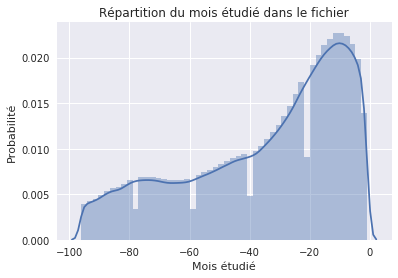

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


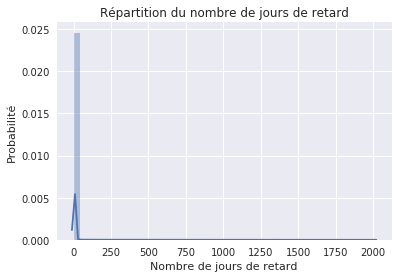

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


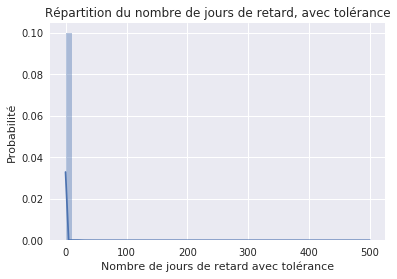

In [ ]:
sns.set()
sns.distplot(pos['MONTHS_BALANCE'])
plt.xlabel('Mois étudié')
plt.ylabel(u'Probabilité')
plt.title("Répartition du mois étudié dans le fichier")
plt.grid(True)
plt.show()

dpd = pos[pos['SK_DPD'] <= 2010]

sns.set()
sns.distplot(dpd['SK_DPD'])
plt.xlabel('Nombre de jours de retard')
plt.ylabel(u'Probabilité')
plt.title('Répartition du nombre de jours de retard')
plt.grid(True)
plt.show()

dpd_def = pos[pos['SK_DPD_DEF'] <= 500]

sns.set()
sns.distplot(dpd_def['SK_DPD_DEF'])
plt.xlabel('Nombre de jours de retard avec tolérance')
plt.ylabel(u'Probabilité')
plt.title("Répartition du nombre de jours de retard, avec tolérance")
plt.grid(True)
plt.show()


Une nouvelle variable pourrait également nous intéresser : 'POS_COUNT', ou le nombre de crédits précédents possédés par client.


Une fois ces variables analysées, nous réalisons donc la fonction qui traitera ce fichier :

- On transforme les variables catégorielles non binaires
- On crée des aggrégations pour les variables numériques d'intérêt vues précédemment, afin d'en tirer des renseignements statisques (min, max, moyenne, ...) , et pour les variables catégorielles.
- On crée la variable "POS_COUNT"

In [ ]:
# Pré-processing du fichier "pos_cash_balance.csv" (Monthly balance snapshots
# of previous POS (point of sales) and cash loans that the applicant had
# with Home Credit.)
# Pas de débogguage ici donc None, et considération des NaN comme de
# potentielles catégories dans cette fonction


def pos_cash(num_rows=None, nan_as_category=True):
    # Importation du fichier entier ("None") "previous_application.csv"
    print ("\n1) Importation du fichier")
    pos = pd.read_csv('POS_CASH_balance.csv', sep=',', nrows=num_rows)
    print("Taille échantillons previous_application: {} demandes".format(
        len(pos)))
    print ("\n2) Traitement des variables catégorielles non-binaires :")
    # Traitement de toutes les variables catégorielles non binaires du fichier
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    print ("\n3) Aggrégations dans le fichier")
    # Création future des valeurs statistiques des variables numériques
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    print ("Aggrégations numériques :", aggregations)
    # Création future des valeurs statistiques des variables catégorielles
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    print ("Aggrégations numériques + catégorielles :", aggregations)
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    print ("Fichier après aggrégation : {}\n".format(pos_agg))
    print ("Noms de colonnes avant renommage :", pos_agg.columns.tolist())
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper()
                                for e in pos_agg.columns.tolist()])
    print ("Noms de colonnes après renommage :", pos_agg.columns)
    # Nombre de comptes POS_CASH par demandeur
    print("\n4)Calcul du nombre de comptes POS_CASH par client")
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    print(pos_agg['POS_COUNT'][0:2])
    del pos
    gc.collect()
    return pos_agg


# 6) Fichier "Installements_payments.csv"

Le fichier "installments_payments.csv" contient les informations sur les paiements des crédits précédents chez Home Credit : chaque ligne parlera d'un paiement de crédit, qu'il ait bien été fait ou qu'il a été manqué. 

In [ ]:
ins = pd.read_csv('installments_payments.csv', sep=',')
print("Taille échantillons previous_application: {} demandes".format(len(ins)))


Taille échantillons previous_application: 13605401 demandes


Nous n'avons ici pas de variables catégorielles binaires à étudier, uniquement des variables catégorielles non-binaires, transformées par la fonction 'one_hot_encoder" créée précédemment, et des variables numériques que nous allons analyser en partie.

- 'NUM_INSTALMENT_VERSION' correspond au numéro de la version du calendrier des versements, 0 étant pour les cartes de crédit. 90% des clients ont au maximum une version, et plus de 99% en ont maximum 5.
- 'AMT_INSTALMENT' est le montant prévu du versement du mois indiqué et 'AMT_PAYMENT' est le montant payé du versement du mois indiqué. Ils sont de 25000 dollars maximum pour plus de 90% des clients.
- 'DAYS_ENTRY_PAYMENT' indique quand les versements ont été effectivement effectués par rapport à la date de la demande actuelle. Si le maximum de temps est de 4921 jours, 50% des clients mettent 750 jours

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


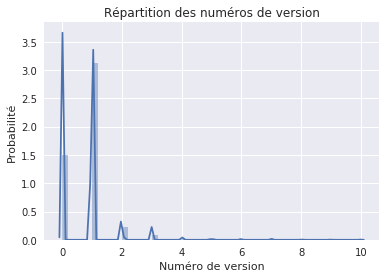

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


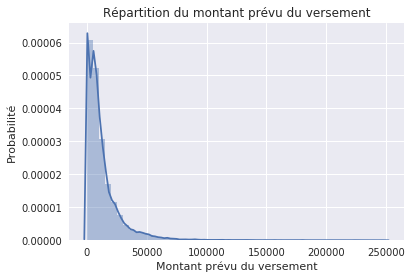

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


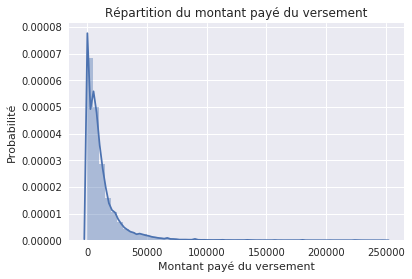

Min de 'DAYS_ENTRY_PAYMENT =  -4921.0


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


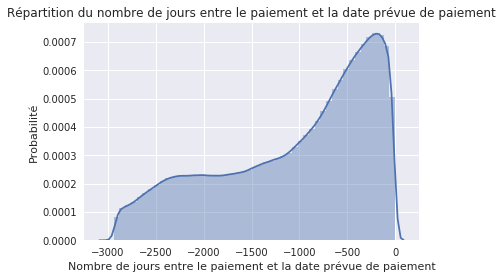

In [ ]:
dpd = ins[ins['NUM_INSTALMENT_VERSION'] <= 10]

sns.set()
sns.distplot(dpd['NUM_INSTALMENT_VERSION'])
plt.xlabel('Numéro de version')
plt.ylabel(u'Probabilité')
plt.title('Répartition des numéros de version')
plt.grid(True)
plt.show()

amti = ins[ins['AMT_INSTALMENT'] <= 2.5E5]

sns.set()
sns.distplot(amti['AMT_INSTALMENT'])
plt.xlabel('Montant prévu du versement')
plt.ylabel(u'Probabilité')
plt.title("Répartition du montant prévu du versement")
plt.grid(True)
plt.show()

amtp = ins[ins['AMT_PAYMENT'] <= 2.5E5]

sns.set()
sns.distplot(amtp['AMT_PAYMENT'])
plt.xlabel('Montant payé du versement')
plt.ylabel(u'Probabilité')
plt.title("Répartition du montant payé du versement")
plt.grid(True)
plt.show()

dep = ins[ins['DAYS_ENTRY_PAYMENT'] >= -3000]

print ("Min de 'DAYS_ENTRY_PAYMENT = ", min(ins['DAYS_ENTRY_PAYMENT']))
sns.set()
sns.distplot(dep['DAYS_ENTRY_PAYMENT'])
plt.xlabel('Nombre de jours entre le paiement et la date prévue de paiement')
plt.ylabel(u'Probabilité')
plt.title("Répartition du nombre de jours entre le paiement et la date"
          "prévue de paiement")
plt.grid(True)
plt.show()


Différentes variables sont également créées afin de nous apporter des informations supplémentaires :
- "PAYMENT_PERC" indique le pourcentage entre la somme versée et la somme due.
- "PAYMENT_DIFF" indique la différence entre la somme versée et la somme due.
- 'DPD" correspond au nombre de jours de retard du versement. Si les valeurs sont négatives, elles sont mises à une valeur nulle (crédit clos)
- 'DBD" correspond au nombre de jours avant la fin du prêt (crédit clos)

Nous ajoutons également une dernière variable, "INSTAL_COUNT", qui correspond au nombre de versements par personne

Une fois ces variables analysées et/ou créées, nous réalisons donc la fonction qui traitera ce fichier :

- On transforme les variables catégorielles non binaires
- On crée nos nouvelles variables
- On crée des aggrégations pour les variables numériques d'intérêt vues précédemment, afin d'en tirer des renseignements statisques (min, max, moyenne, ...) , et pour les variables catégorielles.
- On crée la variable "INSTALL_COUNT"

In [ ]:
# Pré-processing du fichier "installments_payments.csv" (Repayment history for
# the previously disbursed credits in Home Credit related to the loans
# in our sample)
# Pas de débogguage ici donc None, et considération des NaN comme de
# potentielles catégories dans cette fonction


def installments_payments(num_rows=None, nan_as_category=True):
    # Importation du fichier entier ("None") "previous_application.csv"
    print ("\n1) Importation du fichier")
    ins = pd.read_csv('installments_payments.csv', sep=',', nrows=num_rows)
    print("Taille échantillons previous_application: {} demandes".format(
        len(ins)))
    print ("\n2) Traitement des variables catégorielles non-binaires :")
    # Traitement de toutes les variables catégorielles non binaires du fichier
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Calcul du pourcentage et de la différence entre la somme versée et la
    # somme due
    print ("\n3) Calcul du pourcentage et de la différence entre la somme"
           "versée et la somme due")
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    print (ins[['AMT_PAYMENT', 'AMT_INSTALMENT', 'PAYMENT_PERC',
                'PAYMENT_DIFF']][0:2])
    # Calcul du nombre de jours avant la fin du prêt (DB) et du nombre de
    # jours de retard (DP)
    print ("\n4)Calcul du nombre de jours avant la fin du prêt (DB) et du"
           "nombre de jours de retard (DP)")
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    # Remplacement des valeurs négatives par 0
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    print (ins[['DAYS_ENTRY_PAYMENT', "DAYS_INSTALMENT", "DPD", 'DBD']][0:2])
    print ("\n5) Aggrégations dans le fichier")
    # Création future des valeurs statistiques des variables numériques
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    print ("Aggrégations numériques :", aggregations)
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    print ("Aggrégations numériques + catégorielles :", aggregations)
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    print ("Fichier après aggrégation : {}\n".format(ins_agg))
    print ("Noms de colonnes avant renommage :", ins_agg.columns.tolist())
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper()
                               for e in ins_agg.columns.tolist()])
    print ("Noms de colonnes après renommage :", ins_agg.columns)
    # Calcul du nombre de versements par client
    print ("\n6) Calcul du nombre de versements par client")
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    print(ins_agg['INSTAL_COUNT'][0:2])
    del ins
    gc.collect()
    return ins_agg


# 7) Fichier "credit_card_balance"

Le fichier "credit_card_balance.csv" contient les instantanés des soldes mensuels des précédentes cartes de crédit chez Home Credit.

In [ ]:
ins = pd.read_csv('credit_card_balance.csv', sep=',')
print("Taille échantillons credit_card_balance : {} demandes".format(len(ins)))


Taille échantillons credit_card_balance : 3840312 demandes


Nous n'avons ici pas de variables catégorielles binaires à étudier, uniquement des variables catégorielles non-binaires, transformées par la fonction 'one_hot_encoder" créée précédemment, et des variables numériques. Ici, seul SK_ID_CURR va être utilisé dans les aggrégations pour étudier les comportements avec les cartes de crédit.

Nous réalisons donc la fonction qui traitera ce fichier :

- On transforme les variables catégorielles non binaires
- On crée des aggrégations pour la variable "SK_ID_CURR", afin d'en tirer des renseignements statisques (min, max, moyenne, ...)
- On crée la variable "CC_COUNT", indiquant le nombre de lignes de cartes de crédit par client

In [ ]:
# Pré-processing du fichier "credit_card_balance.csv" (Monthly balance
# snapshots of previous credit cards that the applicant has with Home Credit)
# Pas de débogguage ici donc None, et considération des NaN comme de
# potentielles catégories dans cette fonction


def credit_card_balance(num_rows=None, nan_as_category=True):
    # Importation du fichier entier ("None") "previous_application.csv"
    print ("\n1) Importation du fichier")
    cc = pd.read_csv('credit_card_balance.csv', sep=',', nrows=num_rows)
    print("Taille échantillons previous_application: {} demandes".format(
        len(cc)))
    print ("\n2) Traitement des variables catégorielles non-binaires :")
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # Aggrégations
    print ("\n3) Aggrégations dans le fichier")
    # Non considération de la variable "SK_ID_PREV" car nous relions tout à
    # la demande en cours
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    print ("Toutes les colonnes sont aggrégées selon les mêmes statistiques,"
           "pas de sélection ici")
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    print ("Fichier après aggrégation : {}\n".format(cc_agg))
    print ("Noms de colonnes avant renommage :", cc_agg.columns.tolist())
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper()
                               for e in cc_agg.columns.tolist()])
    print ("Noms de colonnes après renommage :", cc_agg.columns)
    # Nombre de lignes de cartes de crédit par client
    print ("\n4) Nombre de lignes de cartes de crédit par client")
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    print(cc_agg['CC_COUNT'][0:2])
    del cc
    gc.collect()
    return cc_agg


# 8) Création du fichier pour la modélisation et lancement des fonctions vues précédemment

Maintenant que toutes les fonctions traitant les différents fichiers ont été créées, nous créons maintenant une fonction main() qui va nous permettre de lancer toutes ces fonctions, et ainsi de créer notre nouveau fichier contenant toutes les valeurs d'intérêt existantes et nouvelles. Ce fichier est enfin enregistré afin d'être utilisé dans un second notebook permettant la création d'un modèle de scoring des différents clients.

In [ ]:
# Indique que le code est lancé sans option de déboggage ?
def main(debug=False):
    # Si déboggage, indiquer 10000 lignes, sinon None (donc ici None) ->
    # en déboggage, prendre 10000 lignes et sinon, tout sera lu
    num_rows = 10000 if debug else None
    if debug:
        print ("Actuellement en débogguage")
    else:
        print ("Pas de débogguage donc Num_rows  = {} ".format(num_rows))
    id_example = 215354
    print ("\nPréprocessing des fichiers 'application_train.csv' et"
           "'application_test.csv'")
    with timer("Process application_train and application_test"):
        # Préprocessing des fichiers "application_train.csv"
        # et "application_test.csv"
        df = application_train_test(num_rows)
    '''print ("\nAffichage pour notre exemple : ")
    example=df[df['SK_ID_CURR'] == id_example]
    for col in example.columns:
        print (example[col])'''
    print ("\nPréprocessing des fichiers 'bureau.csv' et 'bureau_balance.csv'")
    with timer("Process bureau and bureau_balance"):
        # Préprocessing des fichiers "bureau.csv" et "bureau_balance.csv"
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        # Rassemblement des deux fichiers finaux déjà obtenus
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        # Suppression du fichier final des fichiers "bureau" et
        # "bureau_balance"
        del bureau
        # Nettoyage des variables maintenant plus utilisée
        gc.collect()
    '''print ("\nAffichage pour notre exemple : ")
    example=df[df['SK_ID_CURR'] == id_example]
    for col in example.columns:
        print (example[col])'''
    print ("\nPréprocessing du fichier 'previous_application.csv'")
    with timer("Process previous_applications"):
        # Préprocessing du fichier 'previous_application.csv'
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        # Rassemblement des trois fichiers finaux déjà obtenus
        df = df.join(prev, how='left', on='SK_ID_CURR')
        # Suppression du fichier final du fichier "previous_application"
        del prev
        # Nettoyage des variables maintenant plus utilisée
        gc.collect()
    '''print ("\nAffichage pour notre exemple : ")
    example=df[df['SK_ID_CURR'] == id_example]
    for col in example.columns:
      print (example[col]) '''

    print ("\nPréprocessing du fichier 'POS_CASH_balance.csv'")
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    '''print ("\nAffichage pour notre exemple : ")
    example=df[df['SK_ID_CURR'] == id_example]
    for col in example.columns:
      print (example[col]) '''
    print ("\nPréprocessing du fichier 'installments_payments.csv'")
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    '''print ("\nAffichage pour notre exemple : ")
    example=df[df['SK_ID_CURR'] == id_example]
    for col in example.columns:
      print (example[col])'''

    print ("\nPréprocessing du fichier 'credit_card_balance.csv")
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    print ("\nAffichage pour notre exemple : ")
    example = df[df['SK_ID_CURR'] == id_example]
    for col in example.columns:
        print (example[col])
    # File save

    '''print (len(df))
    df.to_csv('data_model.csv', sep='\t', index=False)
    print ("Fichier créé")
    print ("Test enregistrement")
    uploaded = drive.CreateFile({'title': 'data_model.csv'})
    uploaded.SetContentFile('data_model.csv')
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))
    '''


In [ ]:
# Indique que si le code est lancé comme code principal, ceci s'exécutera.
# Sinon, le code ne s'exécutera pas automatiquement.
# Si le script est le script principal, alors __name__ ne contient pas le nom
# du script, il contient la chaîne __main__
if __name__ == "__main__":
    # Nom du fichier de sortie des résultats (contient les scores de
    # chaque demande de crédit)
    submission_file_name = "submission_kernel02.csv"
    # Démarrage du timer calculant l'exécution du code entier
    with timer("\nFull model run"):
        main()


Pas de débogguage donc Num_rows  = None 

Préprocessing des fichiers 'application_train.csv' et 'application_test.csv'

1) Importation des fichiers et concaténation

2) Tri des variables (retrait des XNA aberrants pour le sexe

3) Transformation des valeurs des variables catégorielles binaires en numérique (0/1)
Exemple des variables catégorielles avant traitement :
   CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY
0           M            N               Y
1           F            N               N
2           M            Y               Y
3           F            N               Y
4           M            N               Y
5           M            N               Y
6           F            Y               Y
7           M            Y               Y
8           F            N               Y
9           M            N               Y
Valeurs uniques de CODE_GENDER : 2
Valeurs uniques de FLAG_OWN_CAR : 2
Valeurs uniques de FLAG_OWN_REALTY : 2
Transformation des valeurs pour CODE_GENDER : (

Fichier après aggrégation :              MONTHS_BALANCE           STATUS_0  STATUS_1 STATUS_2 STATUS_3  \
                        min max size      mean      mean     mean     mean   
SK_ID_BUREAU                                                                 
5001709                 -96   0   97  0.000000  0.000000      0.0      0.0   
5001710                 -82   0   83  0.060241  0.000000      0.0      0.0   
5001711                  -3   0    4  0.750000  0.000000      0.0      0.0   
5001712                 -18   0   19  0.526316  0.000000      0.0      0.0   
5001713                 -21   0   22  0.000000  0.000000      0.0      0.0   
5001714                 -14   0   15  0.000000  0.000000      0.0      0.0   
5001715                 -59   0   60  0.000000  0.000000      0.0      0.0   
5001716                 -85   0   86  0.313953  0.000000      0.0      0.0   
5001717                 -21   0   22  0.772727  0.000000      0.0      0.0   
5001718                 -38   0   39


5) Aggrégations du fichier total (variables du fichier 'bureau') :
   SK_ID_CURR  DAYS_CREDIT  DAYS_CREDIT_ENDDATE  DAYS_CREDIT_UPDATE
0      215354         -497               -153.0                -131
1      215354         -208               1075.0                 -20
2      215354         -203                528.0                 -16
3      215354         -203                  NaN                 -16
4      215354         -629               1197.0                 -21
5      215354         -273              27460.0                 -31
6      215354          -43                 79.0                 -22
7      162297        -1896              -1684.0               -1710
8      162297        -1146               -811.0                -840
9      162297        -1146               -484.0                -690
Variables numériques : {'DAYS_CREDIT': ['min', 'max', 'mean', 'var'], 'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'], 'DAYS_CREDIT_UPDATE': ['mean'], 'CREDIT_DAY_OVERDUE': ['max', 'mean

Noms de colonnes après aggrégation et renommage : Index(['ACTIVE_DAYS_CREDIT_MIN', 'ACTIVE_DAYS_CREDIT_MAX',
       'ACTIVE_DAYS_CREDIT_MEAN', 'ACTIVE_DAYS_CREDIT_VAR',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
       'ACTIVE_CREDIT_DAY_OVERDUE_MAX', 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN',
       'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ACTIVE_AMT_CREDIT_SUM_MAX',
       'ACTIVE_AMT_CREDIT_SUM_MEAN', 'ACTIVE_AMT_CREDIT_SUM_SUM',
       'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
       'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM', 'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN', 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
       'ACTIVE_AMT_ANNUITY_MAX', 'ACTIVE_AMT_ANNUITY_MEAN',
       'ACTIVE_CNT_CREDIT_PROLONG_SUM', 'ACTIVE_MONTHS_BALANCE_MIN_MIN',
       'ACTIVE_MONTHS_BALANCE_MAX_MAX', 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN',
       'ACTIVE_MONTHS_BAL

Process bureau and bureau_balance - done in 34s

Préprocessing du fichier 'previous_application.csv'
Taille échantillons previous_application: 1670214 demandes

2) Traitement des variables catégorielles non-binaires :
Liste des colonnes catégorielles non-binaires: ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']
Liste des nouvelles colonnes obtenues: ['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Consumer loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_CONTRACT_TYPE_XNA', 'NAME_CONTRACT_TYPE_nan', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_SATURDAY', 'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'WEEKDAY_APPR_PROCESS_ST

Fichier après aggrégation :            AMT_ANNUITY                          AMT_APPLICATION             \
                   min        max          mean             min        max   
SK_ID_CURR                                                                   
100001        3951.000   3951.000   3951.000000       24835.500    24835.5   
100002        9251.775   9251.775   9251.775000      179055.000   179055.0   
100003        6737.310  98356.995  56553.990000       68809.500   900000.0   
100004        5357.250   5357.250   5357.250000       24282.000    24282.0   
100005        4813.200   4813.200   4813.200000           0.000    44617.5   
100006        2482.920  39954.510  23651.175000           0.000   688500.0   
100007        1834.290  22678.785  12278.805000       17176.500   247500.0   
100008        8019.090  25309.575  15839.696250           0.000   450000.0   
100009        7435.845  17341.605  10051.412143       40455.000   110160.0   
100010       27463.410  27463.410  2

Noms de colonnes dans la variable des crédits approuvés : Index(['SK_ID_PREV', 'SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION',
       'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT',
       ...
       'PRODUCT_COMBINATION_POS household with interest',
       'PRODUCT_COMBINATION_POS household without interest',
       'PRODUCT_COMBINATION_POS industry with interest',
       'PRODUCT_COMBINATION_POS industry without interest',
       'PRODUCT_COMBINATION_POS mobile with interest',
       'PRODUCT_COMBINATION_POS mobile without interest',
       'PRODUCT_COMBINATION_POS other with interest',
       'PRODUCT_COMBINATION_POS others without interest',
       'PRODUCT_COMBINATION_nan', 'APP_CREDIT_PERC'],
      dtype='object', length=181)
Noms de colonnes après aggrégation et renommage : Index(['APPROVED_AMT_ANNUITY_MIN', 'APPROVED_AMT_ANNUITY_MAX',
       'APPROVED_AMT_ANNUITY_MEAN', 'APPROVED_AMT_AP

SK_ID_CURR
100001     9
100002    19
Name: POS_COUNT, dtype: int64
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 15s

Préprocessing du fichier 'installments_payments.csv'

1) Importation du fichier
Taille échantillons previous_application: 13605401 demandes

2) Traitement des variables catégorielles non-binaires :
Liste des colonnes catégorielles non-binaires: []
Liste des nouvelles colonnes obtenues: []

3) Calcul du pourcentage et de la différence entre la somme versée et la somme due
   AMT_PAYMENT  AMT_INSTALMENT  PAYMENT_PERC  PAYMENT_DIFF
0     6948.360        6948.360           1.0           0.0
1     1716.525        1716.525           1.0           0.0

4)Calcul du nombre de jours avant la fin du prêt (DB) et du nombre de jours de retard (DP)
   DAYS_ENTRY_PAYMENT  DAYS_INSTALMENT  DPD  DBD
0             -1187.0          -1180.0  0.0  7.0
1             -2156.0          -2156.0  0.0  0.0

5) Aggrégations dans le fichier
Aggrégations numériques : {'NU

SK_ID_CURR
100001     7
100002    19
Name: INSTAL_COUNT, dtype: int64
Installments payments df shape: (339587, 26)
Process installments payments - done in 35s

Préprocessing du fichier 'credit_card_balance.csv

1) Importation du fichier
Taille échantillons previous_application: 3840312 demandes

2) Traitement des variables catégorielles non-binaires :
Liste des colonnes catégorielles non-binaires: ['NAME_CONTRACT_STATUS']
Liste des nouvelles colonnes obtenues: ['NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand', 'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Sent proposal', 'NAME_CONTRACT_STATUS_Signed', 'NAME_CONTRACT_STATUS_nan']

3) Aggrégations dans le fichier
Toutes les colonnes sont aggrégées selon les mêmes statistiques, pas de sélection ici
Fichier après aggrégation :            MONTHS_BALANCE                             AMT_BALANCE              \
                      min max  mean   sum       

Credit card balance df shape: (103558, 141)
Process credit card balance - done in 22s

Affichage pour notre exemple : 
99355    99355
Name: index, dtype: int64
99355    21181.5
Name: AMT_ANNUITY, dtype: float64
99355    720000.0
Name: AMT_CREDIT, dtype: float64
99355    720000.0
Name: AMT_GOODS_PRICE, dtype: float64
99355    270000.0
Name: AMT_INCOME_TOTAL, dtype: float64
99355    0.0
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64
99355    0.0
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: float64
99355    0.0
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: float64
99355    0.0
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64
99355    0.0
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64
99355    3.0
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64
99355   NaN
Name: APARTMENTS_AVG, dtype: float64
99355   NaN
Name: APARTMENTS_MEDI, dtype: float64
99355   NaN
Name: APARTMENTS_MODE, dtype: float64
99355   NaN
Name: BASEMENTAREA_AVG, dtype: float64
99355   NaN
Name: BASEMENTAREA_MEDI, dtype: float64
9935

99355    0.0
Name: PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN, dtype: float64
99355    0.0
Name: PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN, dtype: float64
99355    0.0
Name: PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN, dtype: float64
99355    0.0
Name: PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN, dtype: float64
99355    0.0
Name: PREV_NAME_CASH_LOAN_PURPOSE_Repairs_MEAN, dtype: float64
99355    0.0
Name: PREV_NAME_CASH_LOAN_PURPOSE_Urgent needs_MEAN, dtype: float64
99355    0.0
Name: PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN, dtype: float64
99355    0.8
Name: PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN, dtype: float64
99355    0.2
Name: PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN, dtype: float64
99355    0.0
Name: PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN, dtype: float64
99355    1.0
Name: PREV_NAME_CONTRACT_STATUS_Approved_MEAN, dtype: float64
99355    0.0
Name: PREV_NAME_CONTRACT_STATUS_Canceled_MEAN, dtype: float64
99355    0.0
Name: PREV_

99355    0.0
Name: CC_NAME_CONTRACT_STATUS_Signed_MEAN, dtype: float64
99355    0.0
Name: CC_NAME_CONTRACT_STATUS_Signed_SUM, dtype: float64
99355    0.0
Name: CC_NAME_CONTRACT_STATUS_Signed_VAR, dtype: float64
99355    0.0
Name: CC_NAME_CONTRACT_STATUS_nan_MIN, dtype: float64
99355    0.0
Name: CC_NAME_CONTRACT_STATUS_nan_MAX, dtype: float64
99355    0.0
Name: CC_NAME_CONTRACT_STATUS_nan_MEAN, dtype: float64
99355    0.0
Name: CC_NAME_CONTRACT_STATUS_nan_SUM, dtype: float64
99355    0.0
Name: CC_NAME_CONTRACT_STATUS_nan_VAR, dtype: float64
99355    30.0
Name: CC_COUNT, dtype: float64

Full model run - done in 147s
